#**INTENT CLASSIFICATION**

###**XGBOOST WITH BERT EMBEDDINGS**

Trial 1 - Basic

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

# ✅ Load datasets
train_df = pd.read_csv("/content/train_data_intent_classification.csv")
val_df = pd.read_csv("/content/validation_data_intent_classification.csv")
test_df = pd.read_csv("/content/test_data_intent_classification.csv")

# 🧠 BERT Embedding class
class BERTEmbedder:
    def __init__(self, model_name='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def encode(self, texts):
        embeddings = []
        for text in tqdm(texts, desc="Embedding"):
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
                cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
        return np.array(embeddings)

# 🔄 Create embeddings
embedder = BERTEmbedder()
X_train = embedder.encode(train_df["Text"].tolist())
X_val = embedder.encode(val_df["Text"].tolist())
X_test = embedder.encode(test_df["Text"].tolist())

# 🏷️ Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["Intent"])
y_val = le.transform(val_df["Intent"])
y_test = le.transform(test_df["Intent"])

# 🚀 Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# 📊 Evaluate
y_pred = model.predict(X_test)
print("\n📈 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding: 100%|██████████| 243/243 [00:52<00:00,  4.62it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:54:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.08724
[1]	validation_0-mlogloss:1.93109
[2]	validation_0-mlogloss:1.79973
[3]	validation_0-mlogloss:1.70485
[4]	validation_0-mlogloss:1.62177
[5]	validation_0-mlogloss:1.53894
[6]	validation_0-mlogloss:1.47963
[7]	validation_0-mlogloss:1.41897
[8]	validation_0-mlogloss:1.36501
[9]	validation_0-mlogloss:1.32970
[10]	validation_0-mlogloss:1.29291
[11]	validation_0-mlogloss:1.25602
[12]	validation_0-mlogloss:1.23022
[13]	validation_0-mlogloss:1.20714
[14]	validation_0-mlogloss:1.17542
[15]	validation_0-mlogloss:1.15186
[16]	validation_0-mlogloss:1.13419
[17]	validation_0-mlogloss:1.11469
[18]	validation_0-mlogloss:1.09882
[19]	validation_0-mlogloss:1.08437
[20]	validation_0-mlogloss:1.07587
[21]	validation_0-mlogloss:1.06457
[22]	validation_0-mlogloss:1.05065
[23]	validation_0-mlogloss:1.03992
[24]	validation_0-mlogloss:1.03551
[25]	validation_0-mlogloss:1.03135
[26]	validation_0-mlogloss:1.02562
[27]	validation_0-mlogloss:1.01420
[28]	validation_0-mlogloss:1.0

Trial 2 - With Hyperparameter Tuning

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
from hyperopt import hp, tpe, Trials, fmin
from sklearn.model_selection import train_test_split

# ✅ Load datasets
train_df = pd.read_csv("/content/train_data_intent_classification.csv")
val_df = pd.read_csv("/content/validation_data_intent_classification.csv")
test_df = pd.read_csv("/content/test_data_intent_classification.csv")

# 🧠 BERT Embedding class
class BERTEmbedder:
    def __init__(self, model_name='bert-base-uncased'):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def encode(self, texts):
        embeddings = []
        for text in tqdm(texts, desc="Embedding"):
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
                cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
        return np.array(embeddings)

# 🔄 Create embeddings
embedder = BERTEmbedder()
X_train = embedder.encode(train_df["Text"].tolist())
X_val = embedder.encode(val_df["Text"].tolist())
X_test = embedder.encode(test_df["Text"].tolist())

# 🏷️ Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["Intent"])
y_val = le.transform(val_df["Intent"])
y_test = le.transform(test_df["Intent"])

# Define options for choices
n_estimators_options = [25, 50, 75, 100]
max_depth_options = [2, 3, 5, 7]

# Define the objective function for Hyperopt
def objective(params):
    model = XGBClassifier(
        n_estimators=n_estimators_options[params['n_estimators']],
        max_depth=max_depth_options[params['max_depth']],
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = model.predict(X_val)

    # Calculate F1 score on validation set
    f1 = f1_score(y_val, y_pred, average='weighted')
    return -f1  # Hyperopt minimizes the objective

# Define the hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', list(range(len(n_estimators_options)))),
    'max_depth': hp.choice('max_depth', list(range(len(max_depth_options)))),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# Run hyperparameter optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

# 🔍 Print the actual hyperparameter values
print("Best hyperparameters found:")
print({
    'n_estimators': n_estimators_options[best['n_estimators']],
    'max_depth': max_depth_options[best['max_depth']],
    'learning_rate': best['learning_rate'],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree']
})

# Train final model with actual values
best_model = XGBClassifier(
    n_estimators=n_estimators_options[best['n_estimators']],
    max_depth=max_depth_options[best['max_depth']],
    learning_rate=best['learning_rate'],
    gamma=best['gamma'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='mlogloss'
)

best_model.fit(X_train, y_train)

# 🧪 Evaluate on test set
y_pred = best_model.predict(X_test)
print("\n📈 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Embedding: 100%|██████████| 243/243 [01:01<00:00,  3.98it/s]


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▏         | 1/50 [00:27<22:44, 27.84s/trial, best loss: -0.6974445523928028]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:31:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|▍         | 2/50 [00:54<21:35, 26.99s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:32:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|▌         | 3/50 [02:46<51:31, 65.78s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|▊         | 4/50 [03:20<40:56, 53.40s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:34:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 5/50 [03:42<31:39, 42.22s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▏        | 6/50 [03:55<23:35, 32.17s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 14%|█▍        | 7/50 [04:08<18:28, 25.78s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 16%|█▌        | 8/50 [04:33<17:50, 25.49s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|█▊        | 9/50 [05:15<21:06, 30.90s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 10/50 [06:38<31:14, 46.87s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:38:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██▏       | 11/50 [07:02<25:54, 39.85s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:38:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|██▍       | 12/50 [08:49<38:07, 60.20s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|██▌       | 13/50 [09:50<37:13, 60.37s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|██▊       | 14/50 [11:38<44:54, 74.86s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:43:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 15/50 [12:06<35:27, 60.79s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:43:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|███▏      | 16/50 [12:46<30:56, 54.62s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███▍      | 17/50 [14:33<38:36, 70.20s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|███▌      | 18/50 [14:58<30:17, 56.79s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:46:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 19/50 [15:37<26:32, 51.39s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 20/50 [16:23<24:53, 49.79s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|████▏     | 21/50 [16:29<17:37, 36.47s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████▍     | 22/50 [16:50<14:54, 31.96s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|████▌     | 23/50 [16:58<11:06, 24.69s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|████▊     | 24/50 [17:24<10:52, 25.08s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 25/50 [18:10<13:06, 31.44s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|█████▏    | 26/50 [18:15<09:23, 23.47s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|█████▍    | 27/50 [18:48<10:09, 26.49s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 56%|█████▌    | 28/50 [19:14<09:36, 26.20s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 58%|█████▊    | 29/50 [20:04<11:39, 33.31s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 30/50 [20:36<10:58, 32.94s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 62%|██████▏   | 31/50 [21:02<09:48, 30.99s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:52:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 64%|██████▍   | 32/50 [21:33<09:16, 30.91s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:52:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 66%|██████▌   | 33/50 [21:40<06:40, 23.55s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 68%|██████▊   | 34/50 [22:22<07:50, 29.38s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 35/50 [22:43<06:38, 26.57s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 72%|███████▏  | 36/50 [22:56<05:16, 22.64s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 74%|███████▍  | 37/50 [23:22<05:06, 23.56s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 76%|███████▌  | 38/50 [23:43<04:33, 22.76s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 78%|███████▊  | 39/50 [23:56<03:38, 19.82s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 40/50 [24:21<03:36, 21.63s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 82%|████████▏ | 41/50 [24:41<03:09, 21.11s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 84%|████████▍ | 42/50 [25:08<03:03, 22.92s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 86%|████████▌ | 43/50 [25:23<02:22, 20.32s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 88%|████████▊ | 44/50 [25:48<02:10, 21.74s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:57:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 45/50 [27:29<03:47, 45.54s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 92%|█████████▏| 46/50 [27:55<02:38, 39.74s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 94%|█████████▍| 47/50 [28:20<01:45, 35.33s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 96%|█████████▌| 48/50 [29:47<01:41, 50.84s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:01:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 98%|█████████▊| 49/50 [30:13<00:43, 43.28s/trial, best loss: -0.7676880154387447]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:01:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 50/50 [31:19<00:00, 37.60s/trial, best loss: -0.7676880154387447]
Best hyperparameters found:
{'n_estimators': 100, 'max_depth': 2, 'learning_rate': np.float64(0.15088593756767862), 'gamma': np.float64(0.29413664986683447), 'subsample': np.float64(0.7333768765641301), 'colsample_bytree': np.float64(0.8512860791735805)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:02:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📈 Classification Report:

                                          precision    recall  f1-score   support

                                 Baggage       0.79      0.75      0.77        20
Booking, Modifications And Cancellations       0.60      0.75      0.67        20
                   Check-In And Boarding       0.50      0.55      0.52        20
                        Customer Support       0.83      0.71      0.77        21
                      Fares And Payments       0.68      0.65      0.67        20
                       Flight Operations       0.71      0.75      0.73        20
                              Irrelevant       0.74      0.95      0.83        21
                     Loyalty And Rewards       0.72      0.62      0.67        21
                                   Other       0.63      0.60      0.62        20
                      Passenger Services       0.71      0.60      0.65        20
                                 Refunds       0.60      0.60      0.6

In [11]:
f1_score(y_test, y_pred, average='macro')

0.6944541866557271

Here’s why 0.69 macro F1 can actually be good:

You're working with 12 classes — which is not easy. Random guess would give you ~8% accuracy.

Your classes (e.g., "Baggage", "Refunds", "Flight Operations") are likely semantically similar in customer queries. That makes classification harder.

You're using BERT embeddings with XGBoost — a strong approach, but not the most advanced end-to-end solution like fine-tuned transformer models.

Compared to your initial baseline (without tuning) which was also around 0.68, maintaining or slightly improving that after tuning suggests your model is learning consistent patterns.

You're using real-world data, not clean benchmark datasets — so a 0.69 macro F1 on this is often considered a decent starting point.

###**BERT MODEL WITH BERT EMBEDDINGS**

In [5]:
pip install transformers datasets accelerate ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 9.4 MB/s eta 0:00:00


In [8]:
pip install --upgrade transformers

In [11]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from datasets import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
)

from transformers import set_seed
from transformers.trainer_utils import IntervalStrategy
from transformers.integrations import WandbCallback

from ray import tune  # Optional, just for uniform interface
import numpy as np

# ✅ Set random seed for reproducibility
set_seed(42)

# ✅ Load and prepare data
train_df = pd.read_csv("/content/train_data_intent_classification.csv")
val_df = pd.read_csv("/content/validation_data_intent_classification.csv")
test_df = pd.read_csv("/content/test_data_intent_classification.csv")

# ✅ Label encoding
le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["Intent"])
val_df["labels"] = le.transform(val_df["Intent"])
test_df["labels"] = le.transform(test_df["Intent"])
num_labels = len(le.classes_)

# ✅ Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[["Text", "labels"]])
val_dataset = Dataset.from_pandas(val_df[["Text", "labels"]])
test_dataset = Dataset.from_pandas(test_df[["Text", "labels"]])

# ✅ Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# ✅ Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# ✅ Model init function
def model_init():
    return BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=num_labels
    )

# ✅ Training arguments (used in each trial)
training_args = TrainingArguments(
    output_dir="./bert-intent",
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.NO,
    logging_strategy=IntervalStrategy.EPOCH,
    report_to="none",
    disable_tqdm=False,
    load_best_model_at_end=False,
    metric_for_best_model="f1_macro",
)

# ✅ Trainer setup
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ✅ Hyperparameter tuning with Optuna
best_run = trainer.hyperparameter_search(
    direction="maximize",
    n_trials=10,
    hp_space=lambda _: {
        "learning_rate": tune.uniform(1e-5, 5e-5),
        "num_train_epochs": tune.choice([3, 4, 5]),
        "per_device_train_batch_size": tune.choice([16, 32]),
        "weight_decay": tune.uniform(0.0, 0.1),
    },
)

print("Best run found:")
print(best_run)

# ✅ Retrain with best hyperparameters
best_model = Trainer(
    model_init=model_init,
    args=TrainingArguments(
        output_dir="./bert-intent-final",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=best_run.hyperparameters["learning_rate"],
        num_train_epochs=best_run.hyperparameters["num_train_epochs"],
        per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
        weight_decay=best_run.hyperparameters["weight_decay"],
        logging_dir="./logs",
        logging_strategy="epoch",
        report_to="none"
    ),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

best_model.train()

# ✅ Final Evaluation
preds_output = best_model.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
print("\n📈 Final Classification Report:\n")
print(classification_report(test_df["labels"], preds, target_names=le.classes_))


Map:   0%|          | 0/1134 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

<ipython-input-11-85f23b033b90>:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-04-25 16:11:27,453	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2025-04-25 16:11:27,454	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+-------------------------------------------------------------------+
| Configuration for experiment     _objective_2025-04-25_16-11-27   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 10                               |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_objective_2025-04-25_16-11-27

Trial status: 10 PENDING
Current time: 2025-04-25 16:11:27. Total running time: 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay |
+--------------------------------

(_objective pid=16807) 2025-04-25 16:11:34.916631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=16807) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=16807) E0000 00:00:1745597494.942522   16858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=16807) E0000 00:00:1745597494.950429   16858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=16807) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=16807) You should probably TRAIN this


Trial status: 1 RUNNING | 9 PENDING
Current time: 2025-04-25 16:11:57. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay |
+--------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00000   RUNNING        2.49816e-05                    3                       16      0.0731994   |
| _objective_f11bf_00001   PENDING        3.39463e-05                    5                       32      0.0155995   |
| _objective_f11bf_00002   PENDING        1.23233e-05                    3                       32      0.0142867   |
| _objective_f11bf_00003   PENDING        3.60355e-05                    3                       32      0.072199

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=16807) {'loss': 2.4211, 'grad_norm': 6.712434768676758, 'learning_rate': 1.6771687698624008e-05, 'epoch': 1.0}


(_objective pid=16807) 
 10%|▉         | 3/31 [00:00<00:01, 27.75it/s]
(_objective pid=16807) 
 19%|█▉        | 6/31 [00:00<00:01, 21.25it/s]
(_objective pid=16807) 
 29%|██▉       | 9/31 [00:00<00:01, 20.13it/s]
(_objective pid=16807) 
 39%|███▊      | 12/31 [00:00<00:00, 19.39it/s]
(_objective pid=16807) 
 45%|████▌     | 14/31 [00:00<00:00, 19.16it/s]
(_objective pid=16807) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.86it/s]
(_objective pid=16807) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.75it/s]
(_objective pid=16807) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.73it/s]
(_objective pid=16807) 
 71%|███████   | 22/31 [00:01<00:00, 18.67it/s]
(_objective pid=16807) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.69it/s]
(_objective pid=16807) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.66it/s]
(_objective pid=16807) 
 90%|█████████ | 28/31 [00:01<00:00, 18.56it/s]
(_objective pid=16807) 
 97%|█████████▋| 30/31 [00:01<00:00, 18.64it/s]



Trial _objective_f11bf_00000 finished iteration 1 at 2025-04-25 16:12:05. Total running time: 37s
+-------------------------------------------------+
| Trial _objective_f11bf_00000 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                          33.97 |
| time_total_s                              33.97 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.35802 |
| eval_f1_macro                           0.28449 |
| eval_f1_weighted                        0.28648 |
| eval_loss                               2.20041 |
| eval_runtime                             1.6398 |
| eval_samples_per_second                 148.186 |
| eval_steps_per_second                    18.904 |
| objective                               0.92899 |
+-------------------------------------------------+
(_objective pid=1

                                                
100%|██████████| 31/31 [00:01<00:00, 18.64it/s]
                                               
 63%|██████▎   | 135/213 [00:47<00:27,  2.89it/s]



Trial status: 1 RUNNING | 9 PENDING
Current time: 2025-04-25 16:12:27. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00000   RUNNING        2.49816e-05                    3                       16      0.0731994          1              33.97       2.20041          0

 67%|██████▋   | 142/213 [00:49<00:24,  2.96it/s]
(_objective pid=16807) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=16807) {'loss': 1.7799, 'grad_norm': 7.752779960632324, 'learning_rate': 8.444486113992507e-06, 'epoch': 2.0}


(_objective pid=16807) 
 10%|▉         | 3/31 [00:00<00:01, 27.07it/s]
(_objective pid=16807) 
 19%|█▉        | 6/31 [00:00<00:01, 21.00it/s]
(_objective pid=16807) 
 29%|██▉       | 9/31 [00:00<00:01, 19.62it/s]
(_objective pid=16807) 
 39%|███▊      | 12/31 [00:00<00:01, 18.76it/s]
(_objective pid=16807) 
 45%|████▌     | 14/31 [00:00<00:00, 18.55it/s]
(_objective pid=16807) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.13it/s]
(_objective pid=16807) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.04it/s]
(_objective pid=16807) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.10it/s]
(_objective pid=16807) 
 71%|███████   | 22/31 [00:01<00:00, 18.08it/s]
(_objective pid=16807) 
 77%|███████▋  | 24/31 [00:01<00:00, 17.86it/s]
(_objective pid=16807) 
 84%|████████▍ | 26/31 [00:01<00:00, 17.95it/s]
(_objective pid=16807) 
 90%|█████████ | 28/31 [00:01<00:00, 17.97it/s]
(_objective pid=16807) 
 97%|█████████▋| 30/31 [00:01<00:00, 18.05it/s]



Trial _objective_f11bf_00000 finished iteration 2 at 2025-04-25 16:12:31. Total running time: 1min 3s
+-------------------------------------------------+
| Trial _objective_f11bf_00000 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.0186 |
| time_total_s                            59.9886 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.80247 |
| eval_f1_macro                           0.79663 |
| eval_f1_weighted                        0.79721 |
| eval_loss                               1.31772 |
| eval_runtime                             1.6952 |
| eval_samples_per_second                 143.342 |
| eval_steps_per_second                    18.286 |
| objective                                2.3963 |
+-------------------------------------------------+
(_objective p

                                                 
100%|██████████| 31/31 [00:01<00:00, 18.05it/s]
                                               
100%|██████████| 213/213 [01:16<00:00,  2.92it/s]
(_objective pid=16807) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=16807) {'loss': 1.1529, 'grad_norm': 7.29221773147583, 'learning_rate': 1.1728452936100705e-07, 'epoch': 3.0}


(_objective pid=16807) 
 10%|▉         | 3/31 [00:00<00:01, 27.08it/s]
(_objective pid=16807) 
 19%|█▉        | 6/31 [00:00<00:01, 20.65it/s]
(_objective pid=16807) 
 29%|██▉       | 9/31 [00:00<00:01, 19.10it/s]
(_objective pid=16807) 
 35%|███▌      | 11/31 [00:00<00:01, 18.42it/s]
(_objective pid=16807) 
 42%|████▏     | 13/31 [00:00<00:00, 18.21it/s]
(_objective pid=16807) 
 48%|████▊     | 15/31 [00:00<00:00, 17.76it/s]
(_objective pid=16807) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.49it/s]
(_objective pid=16807) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.59it/s]
(_objective pid=16807) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.72it/s]
(_objective pid=16807) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.78it/s]



Trial status: 1 RUNNING | 9 PENDING
Current time: 2025-04-25 16:12:57. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00000   RUNNING        2.49816e-05                    3                       16      0.0731994          2            59.9886       1.31772          

(_objective pid=16807) 
 81%|████████  | 25/31 [00:01<00:00, 17.83it/s]
(_objective pid=16807) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.71it/s]
(_objective pid=16807) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.74it/s]
                                                 
100%|██████████| 213/213 [01:18<00:00,  2.72it/s]



Trial _objective_f11bf_00000 finished iteration 3 at 2025-04-25 16:12:58. Total running time: 1min 30s
+-------------------------------------------------+
| Trial _objective_f11bf_00000 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.5872 |
| time_total_s                            86.5757 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.84362 |
| eval_f1_macro                           0.83979 |
| eval_f1_weighted                        0.84037 |
| eval_loss                               1.03704 |
| eval_runtime                             1.7236 |
| eval_samples_per_second                  140.98 |
| eval_steps_per_second                    17.985 |
| objective                               2.52378 |
+-------------------------------------------------+

Trial _obje

(_objective pid=17246) 2025-04-25 16:13:05.565743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=17246) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=17246) E0000 00:00:1745597585.611671   17293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=17246) E0000 00:00:1745597585.629348   17293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=17246) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=17246) You should probably TRAIN this


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2025-04-25 16:13:27. Total running time: 2min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00001   RUNNING          3.39463e-05                    5                       32      0.0155995                                

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17246) {'loss': 2.4275, 'grad_norm': 7.09752893447876, 'learning_rate': 2.7345662268571184e-05, 'epoch': 1.0}


(_objective pid=17246) 
 10%|▉         | 3/31 [00:00<00:01, 26.59it/s]
(_objective pid=17246) 
 19%|█▉        | 6/31 [00:00<00:01, 20.36it/s]
(_objective pid=17246) 
 29%|██▉       | 9/31 [00:00<00:01, 18.93it/s]
(_objective pid=17246) 
 35%|███▌      | 11/31 [00:00<00:01, 18.35it/s]
(_objective pid=17246) 
 42%|████▏     | 13/31 [00:00<00:00, 18.04it/s]
(_objective pid=17246) 
 48%|████▊     | 15/31 [00:00<00:00, 17.77it/s]
(_objective pid=17246) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.48it/s]
(_objective pid=17246) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.64it/s]
(_objective pid=17246) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.76it/s]
(_objective pid=17246) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.74it/s]
(_objective pid=17246) 
 81%|████████  | 25/31 [00:01<00:00, 17.63it/s]
(_objective pid=17246) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.62it/s]
(_objective pid=17246) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.58it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00001 finished iteration 1 at 2025-04-25 16:13:35. Total running time: 2min 7s
+-------------------------------------------------+
| Trial _objective_f11bf_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        32.7259 |
| time_total_s                            32.7259 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.40329 |
| eval_f1_macro                           0.32256 |
| eval_f1_weighted                        0.32506 |
| eval_loss                               2.18515 |
| eval_runtime                             1.7376 |
| eval_samples_per_second                 139.849 |
| eval_steps_per_second                    17.841 |
| objective                               1.05091 |
+-------------------------------------------------+
(_objective p

 40%|████      | 72/180 [00:47<00:58,  1.84it/s]
(_objective pid=17246) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17246) {'loss': 1.7611, 'grad_norm': 8.290102005004883, 'learning_rate': 2.0556394394994888e-05, 'epoch': 2.0}

Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2025-04-25 16:13:57. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_0

(_objective pid=17246) 
 10%|▉         | 3/31 [00:00<00:01, 26.32it/s]
(_objective pid=17246) 
 19%|█▉        | 6/31 [00:00<00:01, 20.36it/s]
(_objective pid=17246) 
 29%|██▉       | 9/31 [00:00<00:01, 19.08it/s]
(_objective pid=17246) 
 35%|███▌      | 11/31 [00:00<00:01, 18.43it/s]
(_objective pid=17246) 
 42%|████▏     | 13/31 [00:00<00:00, 18.25it/s]
(_objective pid=17246) 
 48%|████▊     | 15/31 [00:00<00:00, 17.98it/s]
(_objective pid=17246) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.49it/s]
(_objective pid=17246) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.71it/s]
(_objective pid=17246) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.78it/s]
(_objective pid=17246) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.94it/s]
(_objective pid=17246) 
 81%|████████  | 25/31 [00:01<00:00, 18.01it/s]
(_objective pid=17246) 
 87%|████████▋ | 27/31 [00:01<00:00, 18.05it/s]
(_objective pid=17246) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.96it/s]



Trial _objective_f11bf_00001 finished iteration 2 at 2025-04-25 16:13:59. Total running time: 2min 32s
+-------------------------------------------------+
| Trial _objective_f11bf_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.4415 |
| time_total_s                            57.1674 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.83128 |
| eval_f1_macro                           0.82521 |
| eval_f1_weighted                        0.82548 |
| eval_loss                               1.25789 |
| eval_runtime                             1.7138 |
| eval_samples_per_second                 141.788 |
| eval_steps_per_second                    18.088 |
| objective                               2.48197 |
+-------------------------------------------------+
(_objective 

                                                
100%|██████████| 31/31 [00:01<00:00, 17.96it/s]
                                               
 60%|██████    | 108/180 [01:11<00:38,  1.87it/s]
(_objective pid=17246) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17246) {'loss': 0.9665, 'grad_norm': 5.206270694732666, 'learning_rate': 1.3767126521418597e-05, 'epoch': 3.0}


(_objective pid=17246) 
 10%|▉         | 3/31 [00:00<00:01, 26.05it/s]
(_objective pid=17246) 
 19%|█▉        | 6/31 [00:00<00:01, 20.42it/s]
(_objective pid=17246) 
 29%|██▉       | 9/31 [00:00<00:01, 19.24it/s]
(_objective pid=17246) 
 35%|███▌      | 11/31 [00:00<00:01, 18.63it/s]
(_objective pid=17246) 
 42%|████▏     | 13/31 [00:00<00:00, 18.51it/s]
(_objective pid=17246) 
 48%|████▊     | 15/31 [00:00<00:00, 18.01it/s]
(_objective pid=17246) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.76it/s]
(_objective pid=17246) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.88it/s]
(_objective pid=17246) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.86it/s]
(_objective pid=17246) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.97it/s]
(_objective pid=17246) 
 81%|████████  | 25/31 [00:01<00:00, 17.96it/s]
(_objective pid=17246) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.85it/s]
(_objective pid=17246) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.86it/s]



Trial _objective_f11bf_00001 finished iteration 3 at 2025-04-25 16:14:23. Total running time: 2min 56s
+-------------------------------------------------+
| Trial _objective_f11bf_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0696 |
| time_total_s                            81.2371 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.91358 |
| eval_f1_macro                           0.91195 |
| eval_f1_weighted                        0.91237 |
| eval_loss                               0.69503 |
| eval_runtime                             1.7148 |
| eval_samples_per_second                 141.707 |
| eval_steps_per_second                    18.078 |
| objective                                2.7379 |
+-------------------------------------------------+
(_objective 

                                                 
100%|██████████| 31/31 [00:01<00:00, 17.86it/s]
                                               
 63%|██████▎   | 114/180 [01:16<00:46,  1.42it/s]



Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2025-04-25 16:14:27. Total running time: 3min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00001   RUNNING          3.39463e-05                    5                       32      0.0155995          3            81.2371  

 80%|████████  | 144/180 [01:35<00:19,  1.87it/s]
(_objective pid=17246) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17246) {'loss': 0.5616, 'grad_norm': 4.092287063598633, 'learning_rate': 6.977858647842302e-06, 'epoch': 4.0}


(_objective pid=17246) 
 10%|▉         | 3/31 [00:00<00:01, 27.56it/s]
(_objective pid=17246) 
 19%|█▉        | 6/31 [00:00<00:01, 20.93it/s]
(_objective pid=17246) 
 29%|██▉       | 9/31 [00:00<00:01, 19.40it/s]
(_objective pid=17246) 
 39%|███▊      | 12/31 [00:00<00:01, 18.76it/s]
(_objective pid=17246) 
 45%|████▌     | 14/31 [00:00<00:00, 18.52it/s]
(_objective pid=17246) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.16it/s]
(_objective pid=17246) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.00it/s]
(_objective pid=17246) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.06it/s]
(_objective pid=17246) 
 71%|███████   | 22/31 [00:01<00:00, 18.00it/s]
(_objective pid=17246) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.04it/s]
(_objective pid=17246) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.01it/s]
(_objective pid=17246) 
 90%|█████████ | 28/31 [00:01<00:00, 18.04it/s]
(_objective pid=17246) 
                                                 
100%|██████████| 31/31 [00:01<00:00, 17.94it/s]
                 


Trial _objective_f11bf_00001 finished iteration 4 at 2025-04-25 16:14:47. Total running time: 3min 20s
+-------------------------------------------------+
| Trial _objective_f11bf_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0275 |
| time_total_s                            105.265 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.95062 |
| eval_f1_macro                           0.95044 |
| eval_f1_weighted                        0.95076 |
| eval_loss                                0.4725 |
| eval_runtime                             1.6957 |
| eval_samples_per_second                 143.304 |
| eval_steps_per_second                    18.282 |
| objective                               2.85181 |
+-------------------------------------------------+
(_objective 

 89%|████████▉ | 160/180 [01:47<00:12,  1.58it/s]



Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2025-04-25 16:14:57. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00001   RUNNING          3.39463e-05                    5                       32      0.0155995          4           105.265  

100%|██████████| 180/180 [01:59<00:00,  1.86it/s]
(_objective pid=17246) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17246) {'loss': 0.4024, 'grad_norm': 2.5655324459075928, 'learning_rate': 1.8859077426600818e-07, 'epoch': 5.0}


(_objective pid=17246) 
 10%|▉         | 3/31 [00:00<00:01, 27.34it/s]
(_objective pid=17246) 
 19%|█▉        | 6/31 [00:00<00:01, 20.95it/s]
(_objective pid=17246) 
 29%|██▉       | 9/31 [00:00<00:01, 19.29it/s]
(_objective pid=17246) 
 35%|███▌      | 11/31 [00:00<00:01, 18.70it/s]
(_objective pid=17246) 
 42%|████▏     | 13/31 [00:00<00:00, 18.51it/s]
(_objective pid=17246) 
 48%|████▊     | 15/31 [00:00<00:00, 18.32it/s]
(_objective pid=17246) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.99it/s]
(_objective pid=17246) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.92it/s]
(_objective pid=17246) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.99it/s]
(_objective pid=17246) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.95it/s]
(_objective pid=17246) 
 81%|████████  | 25/31 [00:01<00:00, 17.99it/s]
(_objective pid=17246) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.89it/s]
(_objective pid=17246) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.90it/s]
                                                 
100%|██████████| 


Trial _objective_f11bf_00001 finished iteration 5 at 2025-04-25 16:15:11. Total running time: 3min 44s
+-------------------------------------------------+
| Trial _objective_f11bf_00001 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.2229 |
| time_total_s                            129.487 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.96296 |
| eval_f1_macro                           0.96317 |
| eval_f1_weighted                        0.96333 |
| eval_loss                               0.41621 |
| eval_runtime                             1.7017 |
| eval_samples_per_second                   142.8 |
| eval_steps_per_second                    18.217 |
| objective                               2.88946 |
+-------------------------------------------------+

Trial _obje

(_objective pid=17869) 2025-04-25 16:15:19.820194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=17869) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=17869) E0000 00:00:1745597719.847637   17922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=17869) E0000 00:00:1745597719.856257   17922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=17869) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=17869) You should probably TRAIN this


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-25 16:15:28. Total running time: 4min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00002   RUNNING          1.23233e-05                    3                       32      0.0142867                                

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17869) {'loss': 2.4812, 'grad_norm': 6.263692378997803, 'learning_rate': 8.329668032695763e-06, 'epoch': 1.0}


(_objective pid=17869) 
 10%|▉         | 3/31 [00:00<00:01, 26.86it/s]
(_objective pid=17869) 
 19%|█▉        | 6/31 [00:00<00:01, 20.10it/s]
(_objective pid=17869) 
 29%|██▉       | 9/31 [00:00<00:01, 18.73it/s]
(_objective pid=17869) 
 35%|███▌      | 11/31 [00:00<00:01, 18.21it/s]
(_objective pid=17869) 
 42%|████▏     | 13/31 [00:00<00:01, 17.87it/s]
(_objective pid=17869) 
 48%|████▊     | 15/31 [00:00<00:00, 17.50it/s]
(_objective pid=17869) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.18it/s]
(_objective pid=17869) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.41it/s]
(_objective pid=17869) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.50it/s]
(_objective pid=17869) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.56it/s]
(_objective pid=17869) 
 81%|████████  | 25/31 [00:01<00:00, 17.60it/s]
(_objective pid=17869) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.38it/s]
(_objective pid=17869) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.26it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00002 finished iteration 1 at 2025-04-25 16:15:49. Total running time: 4min 21s
+-------------------------------------------------+
| Trial _objective_f11bf_00002 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        31.6974 |
| time_total_s                            31.6974 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.16049 |
| eval_f1_macro                           0.09191 |
| eval_f1_weighted                        0.09202 |
| eval_loss                               2.38841 |
| eval_runtime                             1.7577 |
| eval_samples_per_second                  138.25 |
| eval_steps_per_second                    17.637 |
| objective                               0.34443 |
+-------------------------------------------------+
(_objective 

 45%|████▌     | 49/108 [00:32<00:38,  1.52it/s]



Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-25 16:15:58. Total running time: 4min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00002   RUNNING          1.23233e-05                    3                       32      0.0142867          1            31.6974 

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=17869) {'loss': 2.3153, 'grad_norm': 9.903168678283691, 'learning_rate': 4.221886537119771e-06, 'epoch': 2.0}


(_objective pid=17869) 
 10%|▉         | 3/31 [00:00<00:01, 27.30it/s]
(_objective pid=17869) 
 19%|█▉        | 6/31 [00:00<00:01, 20.63it/s]
(_objective pid=17869) 
 29%|██▉       | 9/31 [00:00<00:01, 19.18it/s]
(_objective pid=17869) 
 35%|███▌      | 11/31 [00:00<00:01, 18.56it/s]
(_objective pid=17869) 
 42%|████▏     | 13/31 [00:00<00:00, 18.43it/s]
(_objective pid=17869) 
 48%|████▊     | 15/31 [00:00<00:00, 18.09it/s]
(_objective pid=17869) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.88it/s]
(_objective pid=17869) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.95it/s]
(_objective pid=17869) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.98it/s]
(_objective pid=17869) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.94it/s]
(_objective pid=17869) 
 81%|████████  | 25/31 [00:01<00:00, 17.87it/s]
(_objective pid=17869) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.83it/s]
(_objective pid=17869) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.75it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00002 finished iteration 2 at 2025-04-25 16:16:13. Total running time: 4min 46s
+-------------------------------------------------+
| Trial _objective_f11bf_00002 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.6471 |
| time_total_s                            56.3445 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.25926 |
| eval_f1_macro                           0.17266 |
| eval_f1_weighted                        0.17395 |
| eval_loss                               2.23385 |
| eval_runtime                             1.7108 |
| eval_samples_per_second                 142.042 |
| eval_steps_per_second                    18.121 |
| objective                               0.60586 |
+-------------------------------------------------+
(_objective 

 87%|████████▋ | 94/108 [01:03<00:08,  1.59it/s]



Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-25 16:16:28. Total running time: 5min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00002   RUNNING          1.23233e-05                    3                       32      0.0142867          2            56.3445  

 99%|█████████▉| 107/108 [01:11<00:00,  1.59it/s]


(_objective pid=17869) {'loss': 2.1852, 'grad_norm': 9.778595924377441, 'learning_rate': 1.1410504154377758e-07, 'epoch': 3.0}


100%|██████████| 108/108 [01:11<00:00,  1.87it/s]
(_objective pid=17869) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=17869) 
 10%|▉         | 3/31 [00:00<00:01, 27.02it/s]
(_objective pid=17869) 
 19%|█▉        | 6/31 [00:00<00:01, 20.80it/s]
(_objective pid=17869) 
 29%|██▉       | 9/31 [00:00<00:01, 19.46it/s]
(_objective pid=17869) 
 39%|███▊      | 12/31 [00:00<00:01, 18.88it/s]
(_objective pid=17869) 
 45%|████▌     | 14/31 [00:00<00:00, 18.56it/s]
(_objective pid=17869) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.32it/s]
(_objective pid=17869) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.14it/s]
(_objective pid=17869) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.19it/s]
(_objective pid=17869) 
 71%|███████   | 22/31 [00:01<00:00, 18.21it/s]
(_objective pid=17869) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.23it/s]
(_objective pid=17869) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.23it/s]
(_objective pid=17869) 
 90%|█████████ | 28/31 [00:01<00:00, 18.16it/s]
(_objective pid=17869) 
  


Trial _objective_f11bf_00002 finished iteration 3 at 2025-04-25 16:16:37. Total running time: 5min 10s
+-------------------------------------------------+
| Trial _objective_f11bf_00002 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0662 |
| time_total_s                            80.4107 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.32099 |
| eval_f1_macro                           0.24671 |
| eval_f1_weighted                        0.24872 |
| eval_loss                               2.15587 |
| eval_runtime                             1.6818 |
| eval_samples_per_second                 144.486 |
| eval_steps_per_second                    18.432 |
| objective                               0.81642 |
+-------------------------------------------------+

Trial _obje

(_objective pid=18285) 2025-04-25 16:16:44.779089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=18285) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=18285) E0000 00:00:1745597804.803509   18333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=18285) E0000 00:00:1745597804.811167   18333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=18285) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=18285) You should probably TRAIN this


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-25 16:16:58. Total running time: 5min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00003   RUNNING          3.60355e-05                    3                       32      0.0721999                               

  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=18285) 
 10%|▉         | 3/31 [00:00<00:01, 26.91it/s]


(_objective pid=18285) {'loss': 2.4307, 'grad_norm': 6.983544826507568, 'learning_rate': 2.4357355009357876e-05, 'epoch': 1.0}


(_objective pid=18285) 
 19%|█▉        | 6/31 [00:00<00:01, 20.71it/s]
(_objective pid=18285) 
 29%|██▉       | 9/31 [00:00<00:01, 19.16it/s]
(_objective pid=18285) 
 35%|███▌      | 11/31 [00:00<00:01, 18.61it/s]
(_objective pid=18285) 
 42%|████▏     | 13/31 [00:00<00:00, 18.23it/s]
(_objective pid=18285) 
 48%|████▊     | 15/31 [00:00<00:00, 17.74it/s]
(_objective pid=18285) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.37it/s]
(_objective pid=18285) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.49it/s]
(_objective pid=18285) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.54it/s]
(_objective pid=18285) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.52it/s]
(_objective pid=18285) 
 81%|████████  | 25/31 [00:01<00:00, 17.62it/s]
(_objective pid=18285) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.52it/s]
(_objective pid=18285) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.34it/s]



Trial _objective_f11bf_00003 finished iteration 1 at 2025-04-25 16:17:14. Total running time: 5min 47s
+-------------------------------------------------+
| Trial _objective_f11bf_00003 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        32.4514 |
| time_total_s                            32.4514 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.33333 |
| eval_f1_macro                           0.22694 |
| eval_f1_weighted                        0.22983 |
| eval_loss                               2.17638 |
| eval_runtime                             1.7458 |
| eval_samples_per_second                 139.195 |
| eval_steps_per_second                    17.757 |
| objective                                0.7901 |
+-------------------------------------------------+
(_objective 

                                                
100%|██████████| 31/31 [00:01<00:00, 17.34it/s]
                                               
 52%|█████▏    | 56/108 [00:37<00:34,  1.53it/s]



Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-25 16:17:28. Total running time: 6min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00003   RUNNING          3.60355e-05                    3                       32      0.0721999          1            32.4514  

 67%|██████▋   | 72/108 [00:47<00:19,  1.83it/s]
(_objective pid=18285) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=18285) {'loss': 1.8473, 'grad_norm': 8.163479804992676, 'learning_rate': 1.234550870337317e-05, 'epoch': 2.0}


(_objective pid=18285) 
 10%|▉         | 3/31 [00:00<00:01, 25.07it/s]
(_objective pid=18285) 
 19%|█▉        | 6/31 [00:00<00:01, 19.97it/s]
(_objective pid=18285) 
 29%|██▉       | 9/31 [00:00<00:01, 18.73it/s]
(_objective pid=18285) 
 35%|███▌      | 11/31 [00:00<00:01, 18.07it/s]
(_objective pid=18285) 
 42%|████▏     | 13/31 [00:00<00:01, 17.93it/s]
(_objective pid=18285) 
 48%|████▊     | 15/31 [00:00<00:00, 17.63it/s]
(_objective pid=18285) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.39it/s]
(_objective pid=18285) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.48it/s]
(_objective pid=18285) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.56it/s]
(_objective pid=18285) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.58it/s]
(_objective pid=18285) 
 81%|████████  | 25/31 [00:01<00:00, 17.70it/s]
(_objective pid=18285) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.66it/s]
(_objective pid=18285) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.64it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00003 finished iteration 2 at 2025-04-25 16:17:39. Total running time: 6min 12s
+-------------------------------------------------+
| Trial _objective_f11bf_00003 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.7382 |
| time_total_s                            57.1896 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.77778 |
| eval_f1_macro                           0.77558 |
| eval_f1_weighted                        0.77618 |
| eval_loss                               1.46629 |
| eval_runtime                             1.7463 |
| eval_samples_per_second                  139.15 |
| eval_steps_per_second                    17.752 |
| objective                               2.32954 |
+-------------------------------------------------+
(_objective 

 94%|█████████▎| 101/108 [01:07<00:04,  1.59it/s]



Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-25 16:17:58. Total running time: 6min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00003   RUNNING          3.60355e-05                    3                       32      0.0721999          2            57.1896 

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=18285) {'loss': 1.3045, 'grad_norm': 6.3978166580200195, 'learning_rate': 3.33662397388464e-07, 'epoch': 3.0}


(_objective pid=18285) 
 10%|▉         | 3/31 [00:00<00:01, 27.46it/s]
(_objective pid=18285) 
 19%|█▉        | 6/31 [00:00<00:01, 21.07it/s]
(_objective pid=18285) 
 29%|██▉       | 9/31 [00:00<00:01, 19.59it/s]
(_objective pid=18285) 
 39%|███▊      | 12/31 [00:00<00:01, 18.90it/s]
(_objective pid=18285) 
 45%|████▌     | 14/31 [00:00<00:00, 18.70it/s]
(_objective pid=18285) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.33it/s]
(_objective pid=18285) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.23it/s]
(_objective pid=18285) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.13it/s]
(_objective pid=18285) 
 71%|███████   | 22/31 [00:01<00:00, 18.21it/s]
(_objective pid=18285) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.22it/s]
(_objective pid=18285) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.19it/s]
(_objective pid=18285) 
 90%|█████████ | 28/31 [00:01<00:00, 18.22it/s]
(_objective pid=18285) 
                                                 
100%|██████████| 108/108 [01:13<00:00,  1.48it/s]



Trial _objective_f11bf_00003 finished iteration 3 at 2025-04-25 16:18:03. Total running time: 6min 36s
+-------------------------------------------------+
| Trial _objective_f11bf_00003 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.1043 |
| time_total_s                            81.2939 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                            0.8642 |
| eval_f1_macro                           0.86153 |
| eval_f1_weighted                        0.86201 |
| eval_loss                               1.18323 |
| eval_runtime                              1.681 |
| eval_samples_per_second                 144.556 |
| eval_steps_per_second                    18.441 |
| objective                               2.58773 |
+-------------------------------------------------+

Trial _obje

(_objective pid=18694) 2025-04-25 16:18:11.026270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=18694) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=18694) E0000 00:00:1745597891.052176   18749 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=18694) E0000 00:00:1745597891.060022   18749 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=18694) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=18694) You should probably TRAIN this


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-04-25 16:18:28. Total running time: 7min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00004   RUNNING          4.75421e-05                    4                       32      0.0992212                                

 25%|██▌       | 36/144 [00:22<00:58,  1.86it/s]
(_objective pid=18694) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=18694) {'loss': 2.3433, 'grad_norm': 8.555624961853027, 'learning_rate': 3.5986734800754664e-05, 'epoch': 1.0}


(_objective pid=18694) 
 10%|▉         | 3/31 [00:00<00:01, 26.66it/s]
(_objective pid=18694) 
 19%|█▉        | 6/31 [00:00<00:01, 20.59it/s]
(_objective pid=18694) 
 29%|██▉       | 9/31 [00:00<00:01, 19.02it/s]
(_objective pid=18694) 
 35%|███▌      | 11/31 [00:00<00:01, 18.48it/s]
(_objective pid=18694) 
 42%|████▏     | 13/31 [00:00<00:00, 18.22it/s]
(_objective pid=18694) 
 48%|████▊     | 15/31 [00:00<00:00, 17.92it/s]
(_objective pid=18694) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.70it/s]
(_objective pid=18694) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.75it/s]
(_objective pid=18694) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.88it/s]
(_objective pid=18694) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.89it/s]
(_objective pid=18694) 
 81%|████████  | 25/31 [00:01<00:00, 17.79it/s]
(_objective pid=18694) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.75it/s]
(_objective pid=18694) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.66it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00004 finished iteration 1 at 2025-04-25 16:18:40. Total running time: 7min 12s
+-------------------------------------------------+
| Trial _objective_f11bf_00004 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        31.4494 |
| time_total_s                            31.4494 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.46914 |
| eval_f1_macro                            0.3878 |
| eval_f1_weighted                          0.391 |
| eval_loss                               1.88124 |
| eval_runtime                              1.726 |
| eval_samples_per_second                 140.791 |
| eval_steps_per_second                    17.961 |
| objective                               1.24793 |
+-------------------------------------------------+
(_objective 

 44%|████▍     | 64/144 [00:42<00:51,  1.54it/s]



Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-04-25 16:18:58. Total running time: 7min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00004   RUNNING          4.75421e-05                    4                       32      0.0992212          1            31.4494 

 50%|█████     | 72/144 [00:47<00:39,  1.83it/s]
(_objective pid=18694) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=18694) {'loss': 1.3463, 'grad_norm': 8.514718055725098, 'learning_rate': 2.4101207710597157e-05, 'epoch': 2.0}


(_objective pid=18694) 
 10%|▉         | 3/31 [00:00<00:01, 26.53it/s]
(_objective pid=18694) 
 19%|█▉        | 6/31 [00:00<00:01, 20.36it/s]
(_objective pid=18694) 
 29%|██▉       | 9/31 [00:00<00:01, 18.91it/s]
(_objective pid=18694) 
 35%|███▌      | 11/31 [00:00<00:01, 18.29it/s]
(_objective pid=18694) 
 42%|████▏     | 13/31 [00:00<00:00, 18.18it/s]
(_objective pid=18694) 
 48%|████▊     | 15/31 [00:00<00:00, 17.85it/s]
(_objective pid=18694) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.56it/s]
(_objective pid=18694) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.77it/s]
(_objective pid=18694) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.72it/s]
(_objective pid=18694) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.76it/s]
(_objective pid=18694) 
 81%|████████  | 25/31 [00:01<00:00, 17.67it/s]
(_objective pid=18694) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.54it/s]
(_objective pid=18694) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.62it/s]



Trial _objective_f11bf_00004 finished iteration 2 at 2025-04-25 16:19:04. Total running time: 7min 37s
+-------------------------------------------------+
| Trial _objective_f11bf_00004 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.7027 |
| time_total_s                            56.1521 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.88477 |
| eval_f1_macro                            0.8848 |
| eval_f1_weighted                        0.88507 |
| eval_loss                               0.85505 |
| eval_runtime                             1.7312 |
| eval_samples_per_second                 140.367 |
| eval_steps_per_second                    17.907 |
| objective                               2.65464 |
+-------------------------------------------------+
(_objective 

                                                
100%|██████████| 31/31 [00:01<00:00, 17.62it/s]
                                               
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=18694) {'loss': 0.6192, 'grad_norm': 3.709609031677246, 'learning_rate': 1.2215680620439654e-05, 'epoch': 3.0}


(_objective pid=18694) 
 10%|▉         | 3/31 [00:00<00:01, 27.52it/s]
(_objective pid=18694) 
 19%|█▉        | 6/31 [00:00<00:01, 21.10it/s]
(_objective pid=18694) 
 29%|██▉       | 9/31 [00:00<00:01, 19.55it/s]
(_objective pid=18694) 
 39%|███▊      | 12/31 [00:00<00:01, 18.88it/s]
(_objective pid=18694) 
 45%|████▌     | 14/31 [00:00<00:00, 18.71it/s]
(_objective pid=18694) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.40it/s]
(_objective pid=18694) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.26it/s]
(_objective pid=18694) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.24it/s]
(_objective pid=18694) 
 71%|███████   | 22/31 [00:01<00:00, 18.34it/s]



Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-04-25 16:19:28. Total running time: 8min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00004   RUNNING          4.75421e-05                    4                       32      0.0992212          2            56.1521  

(_objective pid=18694) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.28it/s]
(_objective pid=18694) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.27it/s]
(_objective pid=18694) 
 90%|█████████ | 28/31 [00:01<00:00, 18.24it/s]
(_objective pid=18694) 
 97%|█████████▋| 30/31 [00:01<00:00, 18.19it/s]



Trial _objective_f11bf_00004 finished iteration 3 at 2025-04-25 16:19:28. Total running time: 8min 1s
+-------------------------------------------------+
| Trial _objective_f11bf_00004 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.1299 |
| time_total_s                             80.282 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.93827 |
| eval_f1_macro                           0.93751 |
| eval_f1_weighted                        0.93799 |
| eval_loss                               0.46858 |
| eval_runtime                              1.676 |
| eval_samples_per_second                  144.99 |
| eval_steps_per_second                    18.497 |
| objective                               2.81377 |
+-------------------------------------------------+
(_objective p

                                                 
100%|██████████| 31/31 [00:01<00:00, 18.19it/s]
                                               
100%|██████████| 144/144 [01:35<00:00,  1.86it/s]
(_objective pid=18694) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=18694) {'loss': 0.3647, 'grad_norm': 2.5694546699523926, 'learning_rate': 3.3015353028215284e-07, 'epoch': 4.0}


(_objective pid=18694) 
 10%|▉         | 3/31 [00:00<00:01, 26.66it/s]
(_objective pid=18694) 
 19%|█▉        | 6/31 [00:00<00:01, 20.69it/s]
(_objective pid=18694) 
 29%|██▉       | 9/31 [00:00<00:01, 19.25it/s]
(_objective pid=18694) 
 35%|███▌      | 11/31 [00:00<00:01, 18.71it/s]
(_objective pid=18694) 
 42%|████▏     | 13/31 [00:00<00:00, 18.29it/s]
(_objective pid=18694) 
 48%|████▊     | 15/31 [00:00<00:00, 18.19it/s]
(_objective pid=18694) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.85it/s]
(_objective pid=18694) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.81it/s]
(_objective pid=18694) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.59it/s]
(_objective pid=18694) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.73it/s]
(_objective pid=18694) 
 81%|████████  | 25/31 [00:01<00:00, 17.83it/s]
(_objective pid=18694) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.86it/s]
(_objective pid=18694) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.98it/s]
                                                 
100%|██████████| 


Trial _objective_f11bf_00004 finished iteration 4 at 2025-04-25 16:19:52. Total running time: 8min 25s
+-------------------------------------------------+
| Trial _objective_f11bf_00004 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        23.9605 |
| time_total_s                            104.242 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.95473 |
| eval_f1_macro                           0.95435 |
| eval_f1_weighted                        0.95463 |
| eval_loss                                0.3828 |
| eval_runtime                             1.7109 |
| eval_samples_per_second                 142.027 |
| eval_steps_per_second                    18.119 |
| objective                               2.86371 |
+-------------------------------------------------+

Trial _obje

(_objective pid=19201) 2025-04-25 16:19:59.812051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=19201) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=19201) E0000 00:00:1745597999.836847   19248 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=19201) E0000 00:00:1745597999.844496   19248 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=19201) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=19201) You should probably TRAIN this

(_objective pid=19201) {'loss': 2.4275, 'grad_norm': 7.408100605010986, 'learning_rate': 2.6265412374839198e-05, 'epoch': 1.0}


 25%|██▌       | 36/144 [00:22<00:59,  1.82it/s]
(_objective pid=19201) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=19201) 
 10%|▉         | 3/31 [00:00<00:01, 26.67it/s]
(_objective pid=19201) 
 19%|█▉        | 6/31 [00:00<00:01, 20.16it/s]
(_objective pid=19201) 
 29%|██▉       | 9/31 [00:00<00:01, 18.75it/s]
(_objective pid=19201) 
 35%|███▌      | 11/31 [00:00<00:01, 18.07it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-25 16:20:28. Total running time: 9min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00005   RUNNING          3.46993e-05                    4                       32      0.000706631                               

(_objective pid=19201) 
 42%|████▏     | 13/31 [00:00<00:01, 17.75it/s]
(_objective pid=19201) 
 48%|████▊     | 15/31 [00:00<00:00, 17.50it/s]
(_objective pid=19201) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.36it/s]
(_objective pid=19201) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.43it/s]
(_objective pid=19201) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.48it/s]
(_objective pid=19201) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.48it/s]
(_objective pid=19201) 
 81%|████████  | 25/31 [00:01<00:00, 17.46it/s]
(_objective pid=19201) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.00it/s]
(_objective pid=19201) 
 94%|█████████▎| 29/31 [00:01<00:00, 16.94it/s]
                                                
100%|██████████| 31/31 [00:01<00:00, 16.94it/s]
                                               



Trial _objective_f11bf_00005 finished iteration 1 at 2025-04-25 16:20:29. Total running time: 9min 2s
+-------------------------------------------------+
| Trial _objective_f11bf_00005 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                         32.273 |
| time_total_s                             32.273 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                            0.3786 |
| eval_f1_macro                           0.28582 |
| eval_f1_weighted                        0.28877 |
| eval_loss                               2.12321 |
| eval_runtime                             1.7734 |
| eval_samples_per_second                 137.028 |
| eval_steps_per_second                    17.481 |
| objective                               0.95319 |
+-------------------------------------------------+
(_objective p

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=19201) {'loss': 1.7591, 'grad_norm': 7.474666118621826, 'learning_rate': 1.759059727856203e-05, 'epoch': 2.0}


(_objective pid=19201) 
 10%|▉         | 3/31 [00:00<00:01, 27.42it/s]
(_objective pid=19201) 
 19%|█▉        | 6/31 [00:00<00:01, 21.01it/s]
(_objective pid=19201) 
 29%|██▉       | 9/31 [00:00<00:01, 19.27it/s]
(_objective pid=19201) 
 35%|███▌      | 11/31 [00:00<00:01, 18.74it/s]
(_objective pid=19201) 
 42%|████▏     | 13/31 [00:00<00:00, 18.50it/s]
(_objective pid=19201) 
 48%|████▊     | 15/31 [00:00<00:00, 18.30it/s]
(_objective pid=19201) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.84it/s]
(_objective pid=19201) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.91it/s]
(_objective pid=19201) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.97it/s]
(_objective pid=19201) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.92it/s]
(_objective pid=19201) 
 81%|████████  | 25/31 [00:01<00:00, 17.95it/s]
(_objective pid=19201) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.92it/s]
(_objective pid=19201) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.94it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00005 finished iteration 2 at 2025-04-25 16:20:54. Total running time: 9min 26s
+-------------------------------------------------+
| Trial _objective_f11bf_00005 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.6259 |
| time_total_s                            56.8989 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                            0.8107 |
| eval_f1_macro                            0.8047 |
| eval_f1_weighted                        0.80522 |
| eval_loss                               1.29485 |
| eval_runtime                             1.7031 |
| eval_samples_per_second                 142.682 |
| eval_steps_per_second                    18.202 |
| objective                               2.42062 |
+-------------------------------------------------+
(_objective 

 54%|█████▍    | 78/144 [00:53<00:47,  1.40it/s]



Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-25 16:20:58. Total running time: 9min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00005   RUNNING          3.46993e-05                    4                       32      0.000706631        2            56.8989 

 75%|███████▌  | 108/144 [01:11<00:19,  1.88it/s]
(_objective pid=19201) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=19201) {'loss': 1.0379, 'grad_norm': 5.757705211639404, 'learning_rate': 8.915782182284864e-06, 'epoch': 3.0}


(_objective pid=19201) 
 10%|▉         | 3/31 [00:00<00:01, 26.77it/s]
(_objective pid=19201) 
 19%|█▉        | 6/31 [00:00<00:01, 20.80it/s]
(_objective pid=19201) 
 29%|██▉       | 9/31 [00:00<00:01, 19.48it/s]
(_objective pid=19201) 
 39%|███▊      | 12/31 [00:00<00:01, 18.78it/s]
(_objective pid=19201) 
 45%|████▌     | 14/31 [00:00<00:00, 18.57it/s]
(_objective pid=19201) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.30it/s]
(_objective pid=19201) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.17it/s]
(_objective pid=19201) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.23it/s]
(_objective pid=19201) 
 71%|███████   | 22/31 [00:01<00:00, 18.28it/s]
(_objective pid=19201) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.35it/s]
(_objective pid=19201) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.23it/s]
(_objective pid=19201) 
 90%|█████████ | 28/31 [00:01<00:00, 18.25it/s]
(_objective pid=19201) 
 97%|█████████▋| 30/31 [00:01<00:00, 18.24it/s]



Trial _objective_f11bf_00005 finished iteration 3 at 2025-04-25 16:21:18. Total running time: 9min 50s
+-------------------------------------------------+
| Trial _objective_f11bf_00005 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0407 |
| time_total_s                            80.9396 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.90123 |
| eval_f1_macro                           0.89962 |
| eval_f1_weighted                         0.9002 |
| eval_loss                                0.8041 |
| eval_runtime                             1.6802 |
| eval_samples_per_second                 144.626 |
| eval_steps_per_second                     18.45 |
| objective                               2.70105 |
+-------------------------------------------------+
(_objective 

                                                 
100%|██████████| 31/31 [00:01<00:00, 18.24it/s]
                                               
 86%|████████▌ | 124/144 [01:23<00:12,  1.59it/s]



Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-25 16:21:28. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00005   RUNNING          3.46993e-05                    4                       32      0.000706631        3            80.9396 

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=19201) {'loss': 0.7164, 'grad_norm': 4.1650190353393555, 'learning_rate': 2.4096708600769904e-07, 'epoch': 4.0}


(_objective pid=19201) 
 10%|▉         | 3/31 [00:00<00:01, 27.36it/s]
(_objective pid=19201) 
 19%|█▉        | 6/31 [00:00<00:01, 21.00it/s]
(_objective pid=19201) 
 29%|██▉       | 9/31 [00:00<00:01, 19.43it/s]
(_objective pid=19201) 
 39%|███▊      | 12/31 [00:00<00:01, 18.71it/s]
(_objective pid=19201) 
 45%|████▌     | 14/31 [00:00<00:00, 18.44it/s]
(_objective pid=19201) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.24it/s]
(_objective pid=19201) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.06it/s]
(_objective pid=19201) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.13it/s]
(_objective pid=19201) 
 71%|███████   | 22/31 [00:01<00:00, 18.09it/s]
(_objective pid=19201) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.13it/s]
(_objective pid=19201) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.07it/s]
(_objective pid=19201) 
 90%|█████████ | 28/31 [00:01<00:00, 18.05it/s]
(_objective pid=19201) 
 97%|█████████▋| 30/31 [00:01<00:00, 18.00it/s]



Trial _objective_f11bf_00005 finished iteration 4 at 2025-04-25 16:21:42. Total running time: 10min 14s
+-------------------------------------------------+
| Trial _objective_f11bf_00005 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0093 |
| time_total_s                            104.949 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.92181 |
| eval_f1_macro                           0.92121 |
| eval_f1_weighted                        0.92162 |
| eval_loss                                  0.67 |
| eval_runtime                             1.6927 |
| eval_samples_per_second                 143.559 |
| eval_steps_per_second                    18.314 |
| objective                               2.76464 |
+-------------------------------------------------+

Trial _obj

                                                 
100%|██████████| 144/144 [01:37<00:00,  1.48it/s]



Trial _objective_f11bf_00006 started with configuration:
+-------------------------------------------------+
| Trial _objective_f11bf_00006 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.03999 |
+-------------------------------------------------+


(_objective pid=19700) 2025-04-25 16:21:49.451776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=19700) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=19700) E0000 00:00:1745598109.495226   19749 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=19700) E0000 00:00:1745598109.509736   19749 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=19700) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=19700) You should probably TRAIN this


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-04-25 16:21:58. Total running time: 10min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00006   RUNNING          1.09225e-05                    5                       16      0.0399861                              

 20%|█▉        | 70/355 [00:24<01:41,  2.81it/s]


(_objective pid=19700) {'loss': 2.4572, 'grad_norm': 7.2297492027282715, 'learning_rate': 8.768765198513072e-06, 'epoch': 1.0}


  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=19700) 
 10%|▉         | 3/31 [00:00<00:01, 26.42it/s]
(_objective pid=19700) 
 19%|█▉        | 6/31 [00:00<00:01, 20.23it/s]
(_objective pid=19700) 
 29%|██▉       | 9/31 [00:00<00:01, 18.31it/s]
(_objective pid=19700) 
 35%|███▌      | 11/31 [00:00<00:01, 17.69it/s]
(_objective pid=19700) 
 42%|████▏     | 13/31 [00:00<00:01, 17.53it/s]
(_objective pid=19700) 
 48%|████▊     | 15/31 [00:00<00:00, 17.34it/s]
(_objective pid=19700) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.35it/s]
(_objective pid=19700) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.40it/s]
(_objective pid=19700) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.46it/s]
(_objective pid=19700) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.52it/s]
(_objective pid=19700) 
 81%|████████  | 25/31 [00:01<00:00, 17.27it/s]
(_objective pid=19700) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.15it/s]
(_objective pid=19700) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.00it/s]
                            


Trial _objective_f11bf_00006 finished iteration 1 at 2025-04-25 16:22:21. Total running time: 10min 53s
+-------------------------------------------------+
| Trial _objective_f11bf_00006 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        35.0736 |
| time_total_s                            35.0736 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.18519 |
| eval_f1_macro                           0.12727 |
| eval_f1_weighted                        0.12777 |
| eval_loss                               2.37001 |
| eval_runtime                             1.7766 |
| eval_samples_per_second                 136.776 |
| eval_steps_per_second                    17.449 |
| objective                               0.44023 |
+-------------------------------------------------+
(_objective

 26%|██▌       | 91/355 [00:34<01:34,  2.80it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-04-25 16:22:28. Total running time: 11min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00006   RUNNING          1.09225e-05                    5                       16      0.0399861          1            35.0736 

 40%|███▉      | 141/355 [00:51<01:13,  2.89it/s]


(_objective pid=19700) {'loss': 2.1582, 'grad_norm': 16.66330909729004, 'learning_rate': 6.584265798181744e-06, 'epoch': 2.0}


 40%|████      | 142/355 [00:51<01:11,  2.96it/s]
(_objective pid=19700) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=19700) 
 10%|▉         | 3/31 [00:00<00:01, 27.08it/s]
(_objective pid=19700) 
 19%|█▉        | 6/31 [00:00<00:01, 20.89it/s]
(_objective pid=19700) 
 29%|██▉       | 9/31 [00:00<00:01, 19.37it/s]
(_objective pid=19700) 
 35%|███▌      | 11/31 [00:00<00:01, 18.81it/s]
(_objective pid=19700) 
 42%|████▏     | 13/31 [00:00<00:00, 18.53it/s]
(_objective pid=19700) 
 48%|████▊     | 15/31 [00:00<00:00, 18.27it/s]
(_objective pid=19700) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.92it/s]
(_objective pid=19700) 
 61%|██████▏   | 19/31 [00:01<00:00, 18.04it/s]
(_objective pid=19700) 
 68%|██████▊   | 21/31 [00:01<00:00, 18.07it/s]
(_objective pid=19700) 
 74%|███████▍  | 23/31 [00:01<00:00, 18.12it/s]
(_objective pid=19700) 
 81%|████████  | 25/31 [00:01<00:00, 18.05it/s]
(_objective pid=19700) 
 87%|████████▋ | 27/31 [00:01<00:00, 18.04it/s]



Trial _objective_f11bf_00006 finished iteration 2 at 2025-04-25 16:22:48. Total running time: 11min 20s
+-------------------------------------------------+
| Trial _objective_f11bf_00006 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.7022 |
| time_total_s                            61.7757 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.49383 |
| eval_f1_macro                           0.46241 |
| eval_f1_weighted                        0.46262 |
| eval_loss                               1.93517 |
| eval_runtime                             1.6965 |
| eval_samples_per_second                 143.239 |
| eval_steps_per_second                    18.273 |
| objective                               1.41886 |
+-------------------------------------------------+
(_objective

(_objective pid=19700) 
                                                 
100%|██████████| 31/31 [00:01<00:00, 17.95it/s]
                                               
 49%|████▊     | 173/355 [01:04<01:02,  2.91it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-04-25 16:22:58. Total running time: 11min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00006   RUNNING          1.09225e-05                    5                       16      0.0399861          2            61.7757

 60%|█████▉    | 212/355 [01:17<00:49,  2.91it/s]


(_objective pid=19700) {'loss': 1.7307, 'grad_norm': 6.856542587280273, 'learning_rate': 4.399766397850418e-06, 'epoch': 3.0}


 60%|██████    | 213/355 [01:18<00:47,  2.98it/s]
(_objective pid=19700) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=19700) 
 10%|▉         | 3/31 [00:00<00:01, 25.80it/s]
(_objective pid=19700) 
 19%|█▉        | 6/31 [00:00<00:01, 20.57it/s]
(_objective pid=19700) 
 29%|██▉       | 9/31 [00:00<00:01, 19.43it/s]
(_objective pid=19700) 
 35%|███▌      | 11/31 [00:00<00:01, 18.85it/s]
(_objective pid=19700) 
 42%|████▏     | 13/31 [00:00<00:00, 18.67it/s]
(_objective pid=19700) 
 48%|████▊     | 15/31 [00:00<00:00, 18.40it/s]
(_objective pid=19700) 
 55%|█████▍    | 17/31 [00:00<00:00, 18.19it/s]
(_objective pid=19700) 
 61%|██████▏   | 19/31 [00:01<00:00, 18.20it/s]
(_objective pid=19700) 
 68%|██████▊   | 21/31 [00:01<00:00, 18.23it/s]
(_objective pid=19700) 
 74%|███████▍  | 23/31 [00:01<00:00, 18.15it/s]
(_objective pid=19700) 
 81%|████████  | 25/31 [00:01<00:00, 18.12it/s]
(_objective pid=19700) 
 87%|████████▋ | 27/31 [00:01<00:00, 18.17it/s]
(_objective pid=19700) 
 9


Trial _objective_f11bf_00006 finished iteration 3 at 2025-04-25 16:23:14. Total running time: 11min 46s
+-------------------------------------------------+
| Trial _objective_f11bf_00006 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.2122 |
| time_total_s                            87.9879 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.83128 |
| eval_f1_macro                           0.82868 |
| eval_f1_weighted                         0.8295 |
| eval_loss                               1.51095 |
| eval_runtime                             1.6899 |
| eval_samples_per_second                 143.798 |
| eval_steps_per_second                    18.345 |
| objective                               2.48946 |
+-------------------------------------------------+
(_objective

 72%|███████▏  | 255/355 [01:34<00:34,  2.87it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-04-25 16:23:28. Total running time: 12min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00006   RUNNING          1.09225e-05                    5                       16      0.0399861          3            87.9879 

 80%|███████▉  | 283/355 [01:44<00:25,  2.86it/s]


(_objective pid=19700) {'loss': 1.3874, 'grad_norm': 8.124917030334473, 'learning_rate': 2.2152669975190917e-06, 'epoch': 4.0}


  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=19700) 
 10%|▉         | 3/31 [00:00<00:01, 25.15it/s]
(_objective pid=19700) 
 19%|█▉        | 6/31 [00:00<00:01, 20.26it/s]
(_objective pid=19700) 
 29%|██▉       | 9/31 [00:00<00:01, 19.03it/s]
(_objective pid=19700) 
 35%|███▌      | 11/31 [00:00<00:01, 18.47it/s]
(_objective pid=19700) 
 42%|████▏     | 13/31 [00:00<00:00, 18.23it/s]
(_objective pid=19700) 
 48%|████▊     | 15/31 [00:00<00:00, 18.17it/s]
(_objective pid=19700) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.78it/s]
(_objective pid=19700) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.95it/s]
(_objective pid=19700) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.95it/s]
(_objective pid=19700) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.98it/s]
(_objective pid=19700) 
 81%|████████  | 25/31 [00:01<00:00, 17.97it/s]
(_objective pid=19700) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.87it/s]
(_objective pid=19700) 
                                                 
100%|██████████| 31/31 [00


Trial _objective_f11bf_00006 finished iteration 4 at 2025-04-25 16:23:40. Total running time: 12min 13s
+-------------------------------------------------+
| Trial _objective_f11bf_00006 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.3812 |
| time_total_s                            114.369 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.85597 |
| eval_f1_macro                           0.85229 |
| eval_f1_weighted                        0.85296 |
| eval_loss                               1.24786 |
| eval_runtime                             1.7115 |
| eval_samples_per_second                 141.983 |
| eval_steps_per_second                    18.113 |
| objective                               2.56122 |
+-------------------------------------------------+
(_objective

 95%|█████████▍| 336/355 [02:04<00:06,  2.83it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-04-25 16:23:59. Total running time: 12min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00006   RUNNING          1.09225e-05                    5                       16      0.0399861          4           114.369 

100%|█████████▉| 354/355 [02:10<00:00,  2.86it/s]


(_objective pid=19700) {'loss': 1.2121, 'grad_norm': 11.77784252166748, 'learning_rate': 3.0767597187765164e-08, 'epoch': 5.0}


100%|██████████| 355/355 [02:11<00:00,  2.95it/s]
(_objective pid=19700) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=19700) 
 10%|▉         | 3/31 [00:00<00:01, 26.35it/s]
(_objective pid=19700) 
 19%|█▉        | 6/31 [00:00<00:01, 20.31it/s]
(_objective pid=19700) 
 29%|██▉       | 9/31 [00:00<00:01, 19.09it/s]
(_objective pid=19700) 
 35%|███▌      | 11/31 [00:00<00:01, 18.64it/s]
(_objective pid=19700) 
 42%|████▏     | 13/31 [00:00<00:00, 18.45it/s]
(_objective pid=19700) 
 48%|████▊     | 15/31 [00:00<00:00, 18.26it/s]
(_objective pid=19700) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.96it/s]
(_objective pid=19700) 
 61%|██████▏   | 19/31 [00:01<00:00, 18.00it/s]
(_objective pid=19700) 
 68%|██████▊   | 21/31 [00:01<00:00, 18.00it/s]
(_objective pid=19700) 
 74%|███████▍  | 23/31 [00:01<00:00, 18.00it/s]
(_objective pid=19700) 
 81%|████████  | 25/31 [00:01<00:00, 17.96it/s]
(_objective pid=19700) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.93it/s]
(_objective pid=19700) 
 9


Trial _objective_f11bf_00006 finished iteration 5 at 2025-04-25 16:24:07. Total running time: 12min 39s
+-------------------------------------------------+
| Trial _objective_f11bf_00006 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.5687 |
| time_total_s                            140.938 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.86831 |
| eval_f1_macro                           0.86541 |
| eval_f1_weighted                        0.86592 |
| eval_loss                               1.16571 |
| eval_runtime                             1.7045 |
| eval_samples_per_second                 142.563 |
| eval_steps_per_second                    18.187 |
| objective                               2.59964 |
+-------------------------------------------------+

Trial _obj

                                                 
100%|██████████| 355/355 [02:12<00:00,  2.67it/s]



Trial _objective_f11bf_00007 started with configuration:
+-------------------------------------------------+
| Trial _objective_f11bf_00007 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  32 |
| weight_decay                            0.00906 |
+-------------------------------------------------+


(_objective pid=20342) 2025-04-25 16:24:14.766255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=20342) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=20342) E0000 00:00:1745598254.790547   20391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=20342) E0000 00:00:1745598254.797950   20391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=20342) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=20342) You should probably TRAIN this


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-04-25 16:24:29. Total running time: 13min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00007   RUNNING          1.18666e-05                    5                       32      0.00906064                              

 19%|█▉        | 35/180 [00:22<01:33,  1.56it/s]


(_objective pid=20342) {'loss': 2.4635, 'grad_norm': 6.562748908996582, 'learning_rate': 9.559226925772054e-06, 'epoch': 1.0}


 20%|██        | 36/180 [00:22<01:18,  1.84it/s]
(_objective pid=20342) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=20342) 
 10%|▉         | 3/31 [00:00<00:01, 26.53it/s]
(_objective pid=20342) 
 19%|█▉        | 6/31 [00:00<00:01, 20.23it/s]
(_objective pid=20342) 
 29%|██▉       | 9/31 [00:00<00:01, 18.71it/s]
(_objective pid=20342) 
 35%|███▌      | 11/31 [00:00<00:01, 18.00it/s]
(_objective pid=20342) 
 42%|████▏     | 13/31 [00:00<00:01, 17.71it/s]
(_objective pid=20342) 
 48%|████▊     | 15/31 [00:00<00:00, 17.58it/s]
(_objective pid=20342) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.52it/s]
(_objective pid=20342) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.61it/s]
(_objective pid=20342) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.67it/s]
(_objective pid=20342) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.65it/s]
(_objective pid=20342) 
 81%|████████  | 25/31 [00:01<00:00, 17.67it/s]
(_objective pid=20342) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.52it/s]
(_objective pid=20342) 
 94


Trial _objective_f11bf_00007 finished iteration 1 at 2025-04-25 16:24:44. Total running time: 13min 16s
+-------------------------------------------------+
| Trial _objective_f11bf_00007 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        32.7809 |
| time_total_s                            32.7809 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.16872 |
| eval_f1_macro                           0.08504 |
| eval_f1_weighted                        0.08513 |
| eval_loss                               2.35418 |
| eval_runtime                             1.7546 |
| eval_samples_per_second                 138.496 |
| eval_steps_per_second                    17.668 |
| objective                                0.3389 |
+-------------------------------------------------+
(_objective

 33%|███▎      | 59/180 [00:39<01:18,  1.55it/s]



Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-04-25 16:24:59. Total running time: 13min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00007   RUNNING          1.18666e-05                    5                       32      0.00906064         1            32.7809

 39%|███▉      | 71/180 [00:47<01:10,  1.56it/s]


(_objective pid=20342) {'loss': 2.2718, 'grad_norm': 6.887958526611328, 'learning_rate': 7.185901620063129e-06, 'epoch': 2.0}


  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=20342) 
 10%|▉         | 3/31 [00:00<00:01, 26.70it/s]
(_objective pid=20342) 
 19%|█▉        | 6/31 [00:00<00:01, 20.47it/s]
(_objective pid=20342) 
 29%|██▉       | 9/31 [00:00<00:01, 19.15it/s]
(_objective pid=20342) 
 35%|███▌      | 11/31 [00:00<00:01, 18.47it/s]
(_objective pid=20342) 
 42%|████▏     | 13/31 [00:00<00:00, 18.29it/s]
(_objective pid=20342) 
 48%|████▊     | 15/31 [00:00<00:00, 18.08it/s]
(_objective pid=20342) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.51it/s]
(_objective pid=20342) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.68it/s]
(_objective pid=20342) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.83it/s]
(_objective pid=20342) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.89it/s]
(_objective pid=20342) 
 81%|████████  | 25/31 [00:01<00:00, 17.87it/s]
(_objective pid=20342) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.80it/s]



Trial _objective_f11bf_00007 finished iteration 2 at 2025-04-25 16:25:08. Total running time: 13min 41s
+-------------------------------------------------+
| Trial _objective_f11bf_00007 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.6589 |
| time_total_s                            57.4399 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.35391 |
| eval_f1_macro                            0.2938 |
| eval_f1_weighted                          0.295 |
| eval_loss                                2.1511 |
| eval_runtime                             1.7154 |
| eval_samples_per_second                 141.654 |
| eval_steps_per_second                    18.071 |
| objective                               0.94272 |
+-------------------------------------------------+
(_objective

(_objective pid=20342) 
                                                
100%|██████████| 31/31 [00:01<00:00, 17.82it/s]
                                               
 58%|█████▊    | 104/180 [01:09<00:47,  1.60it/s]



Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-04-25 16:25:29. Total running time: 14min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00007   RUNNING          1.18666e-05                    5                       32      0.00906064         2            57.4399 

 59%|█████▉    | 107/180 [01:11<00:45,  1.60it/s]


(_objective pid=20342) {'loss': 2.0701, 'grad_norm': 7.686275959014893, 'learning_rate': 4.812576314354206e-06, 'epoch': 3.0}


 60%|██████    | 108/180 [01:11<00:38,  1.88it/s]
(_objective pid=20342) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=20342) 
 10%|▉         | 3/31 [00:00<00:01, 27.20it/s]
(_objective pid=20342) 
 19%|█▉        | 6/31 [00:00<00:01, 20.25it/s]
(_objective pid=20342) 
 29%|██▉       | 9/31 [00:00<00:01, 19.11it/s]
(_objective pid=20342) 
 35%|███▌      | 11/31 [00:00<00:01, 18.61it/s]
(_objective pid=20342) 
 42%|████▏     | 13/31 [00:00<00:00, 18.56it/s]
(_objective pid=20342) 
 48%|████▊     | 15/31 [00:00<00:00, 18.18it/s]
(_objective pid=20342) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.93it/s]
(_objective pid=20342) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.88it/s]
(_objective pid=20342) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.91it/s]
(_objective pid=20342) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.94it/s]
(_objective pid=20342) 
 81%|████████  | 25/31 [00:01<00:00, 17.99it/s]
(_objective pid=20342) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.93it/s]
(_objective pid=20342) 
 9


Trial _objective_f11bf_00007 finished iteration 3 at 2025-04-25 16:25:32. Total running time: 14min 5s
+-------------------------------------------------+
| Trial _objective_f11bf_00007 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0887 |
| time_total_s                            81.5285 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.44856 |
| eval_f1_macro                           0.37899 |
| eval_f1_weighted                        0.38079 |
| eval_loss                                1.9767 |
| eval_runtime                             1.7107 |
| eval_samples_per_second                 142.051 |
| eval_steps_per_second                    18.122 |
| objective                               1.20834 |
+-------------------------------------------------+
(_objective 

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=20342) {'loss': 1.8969, 'grad_norm': 13.506553649902344, 'learning_rate': 2.4392510086452822e-06, 'epoch': 4.0}


(_objective pid=20342) 
 10%|▉         | 3/31 [00:00<00:01, 27.08it/s]
(_objective pid=20342) 
 19%|█▉        | 6/31 [00:00<00:01, 20.93it/s]
(_objective pid=20342) 
 29%|██▉       | 9/31 [00:00<00:01, 19.43it/s]
(_objective pid=20342) 
 39%|███▊      | 12/31 [00:00<00:01, 18.58it/s]
(_objective pid=20342) 
 45%|████▌     | 14/31 [00:00<00:00, 18.43it/s]
(_objective pid=20342) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.00it/s]
(_objective pid=20342) 
 58%|█████▊    | 18/31 [00:00<00:00, 17.81it/s]
(_objective pid=20342) 
 65%|██████▍   | 20/31 [00:01<00:00, 17.89it/s]
(_objective pid=20342) 
 71%|███████   | 22/31 [00:01<00:00, 17.85it/s]
(_objective pid=20342) 
 77%|███████▋  | 24/31 [00:01<00:00, 17.86it/s]
(_objective pid=20342) 
 84%|████████▍ | 26/31 [00:01<00:00, 17.84it/s]
(_objective pid=20342) 
 90%|█████████ | 28/31 [00:01<00:00, 17.87it/s]
(_objective pid=20342) 
                                                 
100%|██████████| 31/31 [00:01<00:00, 17.86it/s]
                 


Trial _objective_f11bf_00007 finished iteration 4 at 2025-04-25 16:25:56. Total running time: 14min 29s
+-------------------------------------------------+
| Trial _objective_f11bf_00007 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0084 |
| time_total_s                            105.537 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.57202 |
| eval_f1_macro                           0.53263 |
| eval_f1_weighted                        0.53391 |
| eval_loss                               1.82743 |
| eval_runtime                             1.7113 |
| eval_samples_per_second                 141.995 |
| eval_steps_per_second                    18.115 |
| objective                               1.63855 |
+-------------------------------------------------+
(_objective

 82%|████████▏ | 147/180 [01:39<00:28,  1.17it/s]



Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2025-04-25 16:25:59. Total running time: 14min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00007   RUNNING          1.18666e-05                    5                       32      0.00906064         4           105.537 

 99%|█████████▉| 179/180 [01:59<00:00,  1.58it/s]


(_objective pid=20342) {'loss': 1.7893, 'grad_norm': 9.401556968688965, 'learning_rate': 6.592570293635899e-08, 'epoch': 5.0}


  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=20342) 
 10%|▉         | 3/31 [00:00<00:01, 27.30it/s]
(_objective pid=20342) 
 19%|█▉        | 6/31 [00:00<00:01, 20.94it/s]
(_objective pid=20342) 
 29%|██▉       | 9/31 [00:00<00:01, 19.34it/s]
(_objective pid=20342) 
 35%|███▌      | 11/31 [00:00<00:01, 18.76it/s]
(_objective pid=20342) 
 42%|████▏     | 13/31 [00:00<00:00, 18.53it/s]
(_objective pid=20342) 
 48%|████▊     | 15/31 [00:00<00:00, 18.21it/s]
(_objective pid=20342) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.84it/s]
(_objective pid=20342) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.90it/s]
(_objective pid=20342) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.99it/s]
(_objective pid=20342) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.99it/s]
(_objective pid=20342) 
 81%|████████  | 25/31 [00:01<00:00, 18.03it/s]
(_objective pid=20342) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.96it/s]
(_objective pid=20342) 
 94%|█████████▎| 29/31 [00:01<00:00, 18.00it/s]
                            


Trial _objective_f11bf_00007 finished iteration 5 at 2025-04-25 16:26:21. Total running time: 14min 53s
+-------------------------------------------------+
| Trial _objective_f11bf_00007 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.2285 |
| time_total_s                            129.765 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.62551 |
| eval_f1_macro                           0.59315 |
| eval_f1_weighted                        0.59442 |
| eval_loss                                  1.78 |
| eval_runtime                             1.6977 |
| eval_samples_per_second                 143.137 |
| eval_steps_per_second                     18.26 |
| objective                               1.81309 |
+-------------------------------------------------+

Trial _obj

(_objective pid=20941) 2025-04-25 16:26:28.936878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=20941) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=20941) E0000 00:00:1745598388.961773   20995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=20941) E0000 00:00:1745598388.969602   20995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-25 16:26:29. Total running time: 15min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00008   RUNNING          3.47354e-05                    5                       32      0.0592415                               

(_objective pid=20941) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=20941) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=20941) {'loss': 2.4264, 'grad_norm': 7.1837005615234375, 'learning_rate': 2.798132696739948e-05, 'epoch': 1.0}


(_objective pid=20941) 
 10%|▉         | 3/31 [00:00<00:01, 26.86it/s]
(_objective pid=20941) 
 19%|█▉        | 6/31 [00:00<00:01, 19.96it/s]
(_objective pid=20941) 
 29%|██▉       | 9/31 [00:00<00:01, 18.56it/s]
(_objective pid=20941) 
 35%|███▌      | 11/31 [00:00<00:01, 18.04it/s]
(_objective pid=20941) 
 42%|████▏     | 13/31 [00:00<00:01, 17.71it/s]
(_objective pid=20941) 
 48%|████▊     | 15/31 [00:00<00:00, 17.45it/s]
(_objective pid=20941) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.35it/s]
(_objective pid=20941) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.57it/s]
(_objective pid=20941) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.64it/s]
(_objective pid=20941) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.65it/s]
(_objective pid=20941) 
 81%|████████  | 25/31 [00:01<00:00, 17.56it/s]
(_objective pid=20941) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.18it/s]
(_objective pid=20941) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.13it/s]



Trial _objective_f11bf_00008 finished iteration 1 at 2025-04-25 16:26:58. Total running time: 15min 30s
+-------------------------------------------------+
| Trial _objective_f11bf_00008 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        31.7711 |
| time_total_s                            31.7711 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.37449 |
| eval_f1_macro                           0.27306 |
| eval_f1_weighted                        0.27549 |
| eval_loss                               2.11772 |
| eval_runtime                             1.7669 |
| eval_samples_per_second                 137.526 |
| eval_steps_per_second                    17.544 |
| objective                               0.92303 |
+-------------------------------------------------+
(_objective

                                                
100%|██████████| 31/31 [00:01<00:00, 17.13it/s]
                                               
 21%|██        | 37/180 [00:25<02:38,  1.11s/it]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-25 16:26:59. Total running time: 15min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00008   RUNNING          3.47354e-05                    5                       32      0.0592415          1            31.7711

 40%|████      | 72/180 [00:47<00:58,  1.85it/s]
(_objective pid=20941) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=20941) {'loss': 1.7058, 'grad_norm': 10.622823715209961, 'learning_rate': 2.103423889273478e-05, 'epoch': 2.0}


(_objective pid=20941) 
 10%|▉         | 3/31 [00:00<00:01, 27.21it/s]
(_objective pid=20941) 
 19%|█▉        | 6/31 [00:00<00:01, 20.66it/s]
(_objective pid=20941) 
 29%|██▉       | 9/31 [00:00<00:01, 19.31it/s]
(_objective pid=20941) 
 35%|███▌      | 11/31 [00:00<00:01, 18.71it/s]
(_objective pid=20941) 
 42%|████▏     | 13/31 [00:00<00:00, 18.48it/s]
(_objective pid=20941) 
 48%|████▊     | 15/31 [00:00<00:00, 18.26it/s]
(_objective pid=20941) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.77it/s]
(_objective pid=20941) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.81it/s]
(_objective pid=20941) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.92it/s]
(_objective pid=20941) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.86it/s]
(_objective pid=20941) 
 81%|████████  | 25/31 [00:01<00:00, 17.94it/s]
(_objective pid=20941) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.85it/s]
(_objective pid=20941) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.93it/s]
                                                
100%|██████████| 3


Trial _objective_f11bf_00008 finished iteration 2 at 2025-04-25 16:27:22. Total running time: 15min 55s
+-------------------------------------------------+
| Trial _objective_f11bf_00008 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.5731 |
| time_total_s                            56.3442 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.85597 |
| eval_f1_macro                           0.85206 |
| eval_f1_weighted                         0.8529 |
| eval_loss                               1.20617 |
| eval_runtime                             1.7067 |
| eval_samples_per_second                 142.383 |
| eval_steps_per_second                    18.164 |
| objective                               2.56093 |
+-------------------------------------------------+
(_objective

 46%|████▌     | 82/180 [00:55<01:03,  1.53it/s]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-25 16:27:29. Total running time: 16min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00008   RUNNING          3.47354e-05                    5                       32      0.0592415          2            56.3442 

 60%|██████    | 108/180 [01:11<00:38,  1.87it/s]
(_objective pid=20941) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=20941) {'loss': 0.9245, 'grad_norm': 5.128461837768555, 'learning_rate': 1.4087150818070083e-05, 'epoch': 3.0}


(_objective pid=20941) 
 10%|▉         | 3/31 [00:00<00:01, 27.24it/s]
(_objective pid=20941) 
 19%|█▉        | 6/31 [00:00<00:01, 20.98it/s]
(_objective pid=20941) 
 29%|██▉       | 9/31 [00:00<00:01, 19.49it/s]
(_objective pid=20941) 
 39%|███▊      | 12/31 [00:00<00:01, 18.65it/s]
(_objective pid=20941) 
 45%|████▌     | 14/31 [00:00<00:00, 18.48it/s]
(_objective pid=20941) 
 52%|█████▏    | 16/31 [00:00<00:00, 18.25it/s]
(_objective pid=20941) 
 58%|█████▊    | 18/31 [00:00<00:00, 18.22it/s]
(_objective pid=20941) 
 65%|██████▍   | 20/31 [00:01<00:00, 18.19it/s]
(_objective pid=20941) 
 71%|███████   | 22/31 [00:01<00:00, 18.20it/s]
(_objective pid=20941) 
 77%|███████▋  | 24/31 [00:01<00:00, 18.20it/s]
(_objective pid=20941) 
 84%|████████▍ | 26/31 [00:01<00:00, 18.18it/s]
(_objective pid=20941) 
 90%|█████████ | 28/31 [00:01<00:00, 18.12it/s]



Trial _objective_f11bf_00008 finished iteration 3 at 2025-04-25 16:27:46. Total running time: 16min 19s
+-------------------------------------------------+
| Trial _objective_f11bf_00008 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.0474 |
| time_total_s                            80.3916 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.91358 |
| eval_f1_macro                           0.91209 |
| eval_f1_weighted                        0.91252 |
| eval_loss                               0.66388 |
| eval_runtime                             1.6884 |
| eval_samples_per_second                 143.926 |
| eval_steps_per_second                    18.361 |
| objective                               2.73819 |
+-------------------------------------------------+
(_objective

(_objective pid=20941) 
                                                 
100%|██████████| 31/31 [00:01<00:00, 18.09it/s]
                                               
 71%|███████   | 128/180 [01:25<00:32,  1.59it/s]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-25 16:27:59. Total running time: 16min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00008   RUNNING          3.47354e-05                    5                       32      0.0592415          3            80.3916

 80%|████████  | 144/180 [01:36<00:23,  1.54it/s]
(_objective pid=20941) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=20941) {'loss': 0.5237, 'grad_norm': 4.40964937210083, 'learning_rate': 7.1400627434053846e-06, 'epoch': 4.0}


(_objective pid=20941) 
 10%|▉         | 3/31 [00:00<00:01, 26.35it/s]
(_objective pid=20941) 
 19%|█▉        | 6/31 [00:00<00:01, 20.66it/s]
(_objective pid=20941) 
 29%|██▉       | 9/31 [00:00<00:01, 19.31it/s]
(_objective pid=20941) 
 35%|███▌      | 11/31 [00:00<00:01, 18.62it/s]
(_objective pid=20941) 
 42%|████▏     | 13/31 [00:00<00:00, 18.50it/s]
(_objective pid=20941) 
 48%|████▊     | 15/31 [00:00<00:00, 18.26it/s]
(_objective pid=20941) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.67it/s]
(_objective pid=20941) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.78it/s]
(_objective pid=20941) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.93it/s]
(_objective pid=20941) 
 74%|███████▍  | 23/31 [00:01<00:00, 18.04it/s]
(_objective pid=20941) 
 81%|████████  | 25/31 [00:01<00:00, 18.01it/s]
(_objective pid=20941) 
 87%|████████▋ | 27/31 [00:01<00:00, 18.00it/s]
(_objective pid=20941) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.95it/s]



Trial _objective_f11bf_00008 finished iteration 4 at 2025-04-25 16:28:11. Total running time: 16min 44s
+-------------------------------------------------+
| Trial _objective_f11bf_00008 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        25.0175 |
| time_total_s                            105.409 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.94239 |
| eval_f1_macro                            0.9422 |
| eval_f1_weighted                        0.94253 |
| eval_loss                               0.45203 |
| eval_runtime                             1.7064 |
| eval_samples_per_second                 142.405 |
| eval_steps_per_second                    18.167 |
| objective                               2.82711 |
+-------------------------------------------------+
(_objective

                                                 
100%|██████████| 31/31 [00:01<00:00, 17.95it/s]
                                               
 95%|█████████▌| 171/180 [01:55<00:05,  1.57it/s]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-25 16:28:29. Total running time: 17min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00008   RUNNING          3.47354e-05                    5                       32      0.0592415          4           105.409  

100%|██████████| 180/180 [02:00<00:00,  1.84it/s]
(_objective pid=20941) 
  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=20941) {'loss': 0.3685, 'grad_norm': 2.2357017993927, 'learning_rate': 1.929746687406861e-07, 'epoch': 5.0}


(_objective pid=20941) 
 10%|▉         | 3/31 [00:00<00:01, 26.82it/s]
(_objective pid=20941) 
 19%|█▉        | 6/31 [00:00<00:01, 20.67it/s]
(_objective pid=20941) 
 29%|██▉       | 9/31 [00:00<00:01, 18.89it/s]
(_objective pid=20941) 
 35%|███▌      | 11/31 [00:00<00:01, 18.33it/s]
(_objective pid=20941) 
 42%|████▏     | 13/31 [00:00<00:00, 18.23it/s]
(_objective pid=20941) 
 48%|████▊     | 15/31 [00:00<00:00, 17.97it/s]
(_objective pid=20941) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.24it/s]
(_objective pid=20941) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.43it/s]
(_objective pid=20941) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.57it/s]
(_objective pid=20941) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.62it/s]
(_objective pid=20941) 
 81%|████████  | 25/31 [00:01<00:00, 17.71it/s]
(_objective pid=20941) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.59it/s]
(_objective pid=20941) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.29it/s]



Trial _objective_f11bf_00008 finished iteration 5 at 2025-04-25 16:28:36. Total running time: 17min 8s
+-------------------------------------------------+
| Trial _objective_f11bf_00008 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        24.3041 |
| time_total_s                            129.713 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.95885 |
| eval_f1_macro                           0.95889 |
| eval_f1_weighted                        0.95911 |
| eval_loss                               0.40256 |
| eval_runtime                             1.7454 |
| eval_samples_per_second                 139.227 |
| eval_steps_per_second                    17.761 |
| objective                               2.87686 |
+-------------------------------------------------+

Trial _obje

                                                 
100%|██████████| 180/180 [02:02<00:00,  1.47it/s]



Trial _objective_f11bf_00009 started with configuration:
+-------------------------------------------------+
| Trial _objective_f11bf_00009 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.01705 |
+-------------------------------------------------+


(_objective pid=21557) 2025-04-25 16:28:43.700848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_objective pid=21557) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_objective pid=21557) E0000 00:00:1745598523.725302   21610 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_objective pid=21557) E0000 00:00:1745598523.732927   21610 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(_objective pid=21557) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(_objective pid=21557) You should probably TRAIN this


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2025-04-25 16:28:59. Total running time: 17min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00009   RUNNING          1.1858e-05                     5                       16      0.0170524                                          

 20%|█▉        | 70/355 [00:24<01:41,  2.80it/s]


(_objective pid=21557) {'loss': 2.4356, 'grad_norm': 11.476963996887207, 'learning_rate': 9.519816070444998e-06, 'epoch': 1.0}


 20%|██        | 71/355 [00:25<01:38,  2.87it/s]
(_objective pid=21557) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=21557) 
 10%|▉         | 3/31 [00:00<00:01, 24.81it/s]
(_objective pid=21557) 
 19%|█▉        | 6/31 [00:00<00:01, 19.25it/s]
(_objective pid=21557) 
 29%|██▉       | 9/31 [00:00<00:01, 17.83it/s]
(_objective pid=21557) 
 35%|███▌      | 11/31 [00:00<00:01, 17.49it/s]
(_objective pid=21557) 
 42%|████▏     | 13/31 [00:00<00:01, 17.35it/s]
(_objective pid=21557) 
 48%|████▊     | 15/31 [00:00<00:00, 17.20it/s]
(_objective pid=21557) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.26it/s]
(_objective pid=21557) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.35it/s]
(_objective pid=21557) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.12it/s]
(_objective pid=21557) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.21it/s]
(_objective pid=21557) 
 81%|████████  | 25/31 [00:01<00:00, 17.32it/s]
(_objective pid=21557) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.25it/s]


(_objective pid=21557) {'eval_loss': 2.3141989707946777, 'eval_accuracy': 0.2222222222222222, 'eval_f1_macro': 0.13561391717970175, 'eval_f1_weighted': 0.13650793819408982, 'eval_runtime': 1.7963, 'eval_samples_per_second': 135.276, 'eval_steps_per_second': 17.257, 'epoch': 1.0}

Trial _objective_f11bf_00009 finished iteration 1 at 2025-04-25 16:29:15. Total running time: 17min 48s
+-------------------------------------------------+
| Trial _objective_f11bf_00009 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        34.5016 |
| time_total_s                            34.5016 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.22222 |
| eval_f1_macro                           0.13561 |
| eval_f1_weighted                        0.13651 |
| eval_loss                                

(_objective pid=21557) 
                                                
100%|██████████| 31/31 [00:01<00:00, 16.99it/s]
                                               
 31%|███       | 110/355 [00:40<01:26,  2.84it/s]



Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2025-04-25 16:29:29. Total running time: 18min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00009   RUNNING          1.1858e-05                     5                       16      0.0170524          1            34.5016      2.3142 

 40%|███▉      | 141/355 [00:53<02:26,  1.46it/s]


(_objective pid=21557) {'loss': 2.1789, 'grad_norm': 15.797690391540527, 'learning_rate': 7.148212768685015e-06, 'epoch': 2.0}


 40%|████      | 142/355 [00:53<02:01,  1.76it/s]
(_objective pid=21557) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=21557) 
 10%|▉         | 3/31 [00:00<00:01, 27.05it/s]
(_objective pid=21557) 
 19%|█▉        | 6/31 [00:00<00:01, 20.15it/s]
(_objective pid=21557) 
 29%|██▉       | 9/31 [00:00<00:01, 19.18it/s]
(_objective pid=21557) 
 35%|███▌      | 11/31 [00:00<00:01, 18.64it/s]
(_objective pid=21557) 
 42%|████▏     | 13/31 [00:00<00:00, 18.51it/s]
(_objective pid=21557) 
 48%|████▊     | 15/31 [00:00<00:00, 18.38it/s]
(_objective pid=21557) 
 55%|█████▍    | 17/31 [00:00<00:00, 18.24it/s]
(_objective pid=21557) 
 61%|██████▏   | 19/31 [00:01<00:00, 18.27it/s]
(_objective pid=21557) 
 68%|██████▊   | 21/31 [00:01<00:00, 18.19it/s]
(_objective pid=21557) 
 74%|███████▍  | 23/31 [00:01<00:00, 18.11it/s]
(_objective pid=21557) 
 81%|████████  | 25/31 [00:01<00:00, 18.01it/s]
(_objective pid=21557) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.99it/s]
(_objective pid=21557) 
 9


Trial _objective_f11bf_00009 finished iteration 2 at 2025-04-25 16:29:44. Total running time: 18min 16s
+-------------------------------------------------+
| Trial _objective_f11bf_00009 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        28.6607 |
| time_total_s                            63.1623 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.41152 |
| eval_f1_macro                            0.3717 |
| eval_f1_weighted                        0.37224 |
| eval_loss                               1.99292 |
| eval_runtime                             1.7007 |
| eval_samples_per_second                 142.881 |
| eval_steps_per_second                    18.228 |
| objective                               1.15546 |
+-------------------------------------------------+
(_objective

 52%|█████▏    | 186/355 [01:10<00:58,  2.88it/s]



Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2025-04-25 16:29:59. Total running time: 18min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00009   RUNNING          1.1858e-05                     5                       16      0.0170524          2            63.1623      1.9929

 60%|█████▉    | 212/355 [01:19<00:49,  2.87it/s]


(_objective pid=21557) {'loss': 1.7919, 'grad_norm': 11.360771179199219, 'learning_rate': 4.776609466925034e-06, 'epoch': 3.0}


 60%|██████    | 213/355 [01:20<00:48,  2.96it/s]
(_objective pid=21557) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=21557) 
 10%|▉         | 3/31 [00:00<00:01, 26.81it/s]
(_objective pid=21557) 
 19%|█▉        | 6/31 [00:00<00:01, 20.76it/s]
(_objective pid=21557) 
 29%|██▉       | 9/31 [00:00<00:01, 19.43it/s]
(_objective pid=21557) 
 35%|███▌      | 11/31 [00:00<00:01, 18.89it/s]
(_objective pid=21557) 
 42%|████▏     | 13/31 [00:00<00:00, 18.76it/s]
(_objective pid=21557) 
 48%|████▊     | 15/31 [00:00<00:00, 18.47it/s]
(_objective pid=21557) 
 55%|█████▍    | 17/31 [00:00<00:00, 18.03it/s]
(_objective pid=21557) 
 61%|██████▏   | 19/31 [00:01<00:00, 18.00it/s]
(_objective pid=21557) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.95it/s]
(_objective pid=21557) 
 74%|███████▍  | 23/31 [00:01<00:00, 18.06it/s]
(_objective pid=21557) 
 81%|████████  | 25/31 [00:01<00:00, 18.03it/s]
(_objective pid=21557) 
 87%|████████▋ | 27/31 [00:01<00:00, 18.10it/s]
(_objective pid=21557) 
 9


Trial _objective_f11bf_00009 finished iteration 3 at 2025-04-25 16:30:10. Total running time: 18min 43s
+-------------------------------------------------+
| Trial _objective_f11bf_00009 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.3324 |
| time_total_s                            89.4947 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.77366 |
| eval_f1_macro                           0.76367 |
| eval_f1_weighted                        0.76478 |
| eval_loss                               1.57697 |
| eval_runtime                              1.694 |
| eval_samples_per_second                 143.447 |
| eval_steps_per_second                      18.3 |
| objective                               2.30212 |
+-------------------------------------------------+
(_objective

                                                 
100%|██████████| 31/31 [00:01<00:00, 18.06it/s]
                                               
 75%|███████▌  | 268/355 [01:41<00:30,  2.87it/s]



Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2025-04-25 16:30:29. Total running time: 19min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00009   RUNNING          1.1858e-05                     5                       16      0.0170524          3            89.4948      1.57697

  0%|          | 0/31 [00:00<?, ?it/s]


(_objective pid=21557) {'loss': 1.4463, 'grad_norm': 8.009855270385742, 'learning_rate': 2.405006165165052e-06, 'epoch': 4.0}


(_objective pid=21557) 
 10%|▉         | 3/31 [00:00<00:01, 27.08it/s]
(_objective pid=21557) 
 19%|█▉        | 6/31 [00:00<00:01, 20.57it/s]
(_objective pid=21557) 
 29%|██▉       | 9/31 [00:00<00:01, 18.94it/s]
(_objective pid=21557) 
 35%|███▌      | 11/31 [00:00<00:01, 18.48it/s]
(_objective pid=21557) 
 42%|████▏     | 13/31 [00:00<00:00, 18.36it/s]
(_objective pid=21557) 
 48%|████▊     | 15/31 [00:00<00:00, 17.99it/s]
(_objective pid=21557) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.89it/s]
(_objective pid=21557) 
 61%|██████▏   | 19/31 [00:01<00:00, 17.74it/s]
(_objective pid=21557) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.87it/s]
(_objective pid=21557) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.93it/s]
(_objective pid=21557) 
 81%|████████  | 25/31 [00:01<00:00, 17.94it/s]
(_objective pid=21557) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.93it/s]
(_objective pid=21557) 
 94%|█████████▎| 29/31 [00:01<00:00, 17.93it/s]
                                                 
100%|██████████| 


Trial _objective_f11bf_00009 finished iteration 4 at 2025-04-25 16:30:37. Total running time: 19min 9s
+-------------------------------------------------+
| Trial _objective_f11bf_00009 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.4803 |
| time_total_s                            115.975 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.85185 |
| eval_f1_macro                           0.84932 |
| eval_f1_weighted                         0.8499 |
| eval_loss                                1.3103 |
| eval_runtime                             1.7113 |
| eval_samples_per_second                 142.001 |
| eval_steps_per_second                    18.115 |
| objective                               2.55107 |
+-------------------------------------------------+
(_objective 

 98%|█████████▊| 349/355 [02:11<00:02,  2.85it/s]



Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2025-04-25 16:31:00. Total running time: 19min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     eval_loss     eval_accuracy     eval_f1_macro     eval_f1_weighted |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_f11bf_00009   RUNNING          1.1858e-05                     5                       16      0.0170524          4           115.975       1.3103

100%|█████████▉| 354/355 [02:12<00:00,  2.84it/s]


(_objective pid=21557) {'loss': 1.2626, 'grad_norm': 9.892385482788086, 'learning_rate': 3.340286340507017e-08, 'epoch': 5.0}


100%|██████████| 355/355 [02:13<00:00,  2.94it/s]
(_objective pid=21557) 
  0%|          | 0/31 [00:00<?, ?it/s]
(_objective pid=21557) 
 10%|▉         | 3/31 [00:00<00:01, 26.02it/s]
(_objective pid=21557) 
 19%|█▉        | 6/31 [00:00<00:01, 20.24it/s]
(_objective pid=21557) 
 29%|██▉       | 9/31 [00:00<00:01, 19.08it/s]
(_objective pid=21557) 
 35%|███▌      | 11/31 [00:00<00:01, 18.62it/s]
(_objective pid=21557) 
 42%|████▏     | 13/31 [00:00<00:00, 18.44it/s]
(_objective pid=21557) 
 48%|████▊     | 15/31 [00:00<00:00, 18.30it/s]
(_objective pid=21557) 
 55%|█████▍    | 17/31 [00:00<00:00, 17.93it/s]
(_objective pid=21557) 
 61%|██████▏   | 19/31 [00:01<00:00, 18.05it/s]
(_objective pid=21557) 
 68%|██████▊   | 21/31 [00:01<00:00, 17.85it/s]
(_objective pid=21557) 
 74%|███████▍  | 23/31 [00:01<00:00, 17.89it/s]
(_objective pid=21557) 
 81%|████████  | 25/31 [00:01<00:00, 17.91it/s]
(_objective pid=21557) 
 87%|████████▋ | 27/31 [00:01<00:00, 17.99it/s]
(_objective pid=21557) 
 9


Trial _objective_f11bf_00009 finished iteration 5 at 2025-04-25 16:31:03. Total running time: 19min 36s
+-------------------------------------------------+
| Trial _objective_f11bf_00009 result             |
+-------------------------------------------------+
| checkpoint_dir_name                             |
| time_this_iter_s                        26.5267 |
| time_total_s                            142.502 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.86008 |
| eval_f1_macro                           0.85775 |
| eval_f1_weighted                        0.85823 |
| eval_loss                               1.22379 |
| eval_runtime                             1.7078 |
| eval_samples_per_second                 142.287 |
| eval_steps_per_second                    18.152 |
| objective                               2.57606 |
+-------------------------------------------------+

Trial _obj

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,2.427500,2.185152,0.403292,0.322559,0.325056
2,1.761100,1.257894,0.831276,0.825209,0.825483
3,0.966500,0.695031,0.913580,0.911949,0.912375
4,0.561600,0.472496,0.950617,0.950436,0.950761
5,0.402400,0.416209,0.962963,0.963166,0.963333



📈 Final Classification Report:

                                          precision    recall  f1-score   support

                                 Baggage       1.00      0.95      0.97        20
Booking, Modifications And Cancellations       0.83      0.95      0.88        20
                   Check-In And Boarding       1.00      0.90      0.95        20
                        Customer Support       0.95      0.90      0.93        21
                      Fares And Payments       0.89      0.85      0.87        20
                       Flight Operations       1.00      1.00      1.00        20
                              Irrelevant       1.00      1.00      1.00        21
                     Loyalty And Rewards       0.95      1.00      0.98        21
                                   Other       0.86      0.95      0.90        20
                      Passenger Services       0.95      0.90      0.92        20
                                 Refunds       0.90      0.95   

In [17]:
import os
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# ✅ Base directory where checkpoints are saved
base_dir = "./bert-intent-final"

# ✅ Get all checkpoint directories
checkpoints = sorted(
    [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.startswith("checkpoint")],
    key=lambda x: int(x.split("-")[-1])
)

print(f"Found {len(checkpoints)} checkpoints.")

# ✅ Define metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# ✅ Track best
best_score = 0
best_checkpoint = None
scores_by_ckpt = {}

# ✅ Evaluate each checkpoint
for ckpt in checkpoints:
    print(f"Evaluating {ckpt}...")
    model = BertForSequenceClassification.from_pretrained(ckpt)
    tokenizer = BertTokenizer.from_pretrained(ckpt)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        eval_dataset=val_dataset,
    )

    metrics = trainer.evaluate()
    scores_by_ckpt[ckpt] = metrics["eval_f1_macro"]

    if metrics["eval_f1_macro"] > best_score:
        best_score = metrics["eval_f1_macro"]
        best_checkpoint = ckpt

# ✅ Summary
print("\n🏁 Evaluation Summary:")
for ckpt, score in scores_by_ckpt.items():
    print(f"{ckpt}: F1-macro = {score:.4f}")

print(f"\n✅ Best checkpoint: {best_checkpoint} with F1-macro = {best_score:.4f}")


Found 5 checkpoints.
Evaluating ./bert-intent-final/checkpoint-36...


<ipython-input-17-53e460e4e67e>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Evaluating ./bert-intent-final/checkpoint-72...


<ipython-input-17-53e460e4e67e>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluating ./bert-intent-final/checkpoint-108...


<ipython-input-17-53e460e4e67e>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluating ./bert-intent-final/checkpoint-144...


<ipython-input-17-53e460e4e67e>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluating ./bert-intent-final/checkpoint-180...


<ipython-input-17-53e460e4e67e>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🏁 Evaluation Summary:
./bert-intent-final/checkpoint-36: F1-macro = 0.3226
./bert-intent-final/checkpoint-72: F1-macro = 0.8252
./bert-intent-final/checkpoint-108: F1-macro = 0.9119
./bert-intent-final/checkpoint-144: F1-macro = 0.9504
./bert-intent-final/checkpoint-180: F1-macro = 0.9632

✅ Best checkpoint: ./bert-intent-final/checkpoint-180 with F1-macro = 0.9632


In [20]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy the checkpoint to your Drive
src = "/content/bert-intent-final/checkpoint-180"
dst = "/content/drive/MyDrive/FINAL_best_bert_model_checkpoint"

shutil.copytree(src, dst)

print("✅ Model checkpoint saved to Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model checkpoint saved to Google Drive.


In [21]:
import shutil

shutil.make_archive("checkpoint-180", 'zip', "./bert-intent-final/checkpoint-180")

'/content/checkpoint-180.zip'

In [23]:
from google.colab import files
files.download("checkpoint-180.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###**DISTILBERT WITH BERT EMBEDDINGS**

In [12]:
pip install -U ray[tune] optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00


In [24]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
import optuna

# ✅ Load datasets
train_df = pd.read_csv("/content/train_data_intent_classification.csv")
val_df = pd.read_csv("/content/validation_data_intent_classification.csv")
test_df = pd.read_csv("/content/test_data_intent_classification.csv")

# 🏷️ Encode target labels
le = LabelEncoder()
train_df['Intent'] = le.fit_transform(train_df["Intent"])
val_df['Intent'] = le.transform(val_df["Intent"])
test_df['Intent'] = le.transform(test_df["Intent"])

# 🔄 Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['Text', 'Intent']])
val_dataset = Dataset.from_pandas(val_df[['Text', 'Intent']])
test_dataset = Dataset.from_pandas(test_df[['Text', 'Intent']])

train_dataset = train_dataset.rename_column("Intent", "labels")
val_dataset = val_dataset.rename_column("Intent", "labels")
test_dataset = test_dataset.rename_column("Intent", "labels")

# 🧠 Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(le.classes_)
)

# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['Text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 🧪 Define training args template
def model_init():
    return DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=len(le.classes_)
    )

# 🔍 Define hyperparameter search space
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

# 📦 Setup training arguments (constant part)
training_args = TrainingArguments(
    output_dir="./distilbert-intent2",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# 🤖 Create Trainer instance
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 🧪 Hyperparameter search
best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=hp_space,
    n_trials=3,
)

# ✅ Train final model with best hyperparameters
print("Best hyperparameters:", best_trial.hyperparameters)

final_args = TrainingArguments(
    output_dir="./distilbert-intent-final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_trial.hyperparameters["learning_rate"],
    per_device_train_batch_size=best_trial.hyperparameters["per_device_train_batch_size"],
    weight_decay=best_trial.hyperparameters["weight_decay"],
    num_train_epochs=3,
    logging_dir="./logs-final",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

final_trainer = Trainer(
    model=model_init(),
    args=final_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

final_trainer.train()

# 📊 Evaluate on test set
test_results = final_trainer.predict(test_dataset)
print("\n📈 Test Results:\n")
print(test_results.metrics)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1134 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-25 17:39:36,448] A new study created in memory with name: no-name-dcaf1851-f427-4b35-a35f-15a1b1ed89ce
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇██
eval/f1_macro,▁▆▇██
eval/f1_weighted,▁▆▇██
eval/loss,██▄▂▁▁
eval/model_preparation_time,█▁▃▁▂
eval/runtime,▁███▇▇
eval/samples_per_second,█▁▁▁▁▁
eval/steps_per_second,█▁▁▁▁▁
train/epoch,▁
train/global_step,█▁▁▁▁▁
eval/accuracy,0.96296


Epoch,Training Loss,Validation Loss
1,No log,2.357688
2,No log,2.082986
3,No log,1.963924


[I 2025-04-25 17:42:47,473] Trial 0 finished with value: 1.963923692703247 and parameters: {'learning_rate': 1.6513403424841482e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.12530271943959922}. Best is trial 0 with value: 1.963923692703247.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/loss,█▃▁
eval/runtime,█▁▂
eval/samples_per_second,▁█▇
eval/steps_per_second,▁█▇
train/epoch,▁▅██
train/global_step,▁▅██
eval/loss,1.96392
eval/runtime,3.5622
eval/samples_per_second,68.216
eval/steps_per_second,8.702
total_flos,450734457987072.0


Epoch,Training Loss,Validation Loss
1,No log,2.381616
2,No log,2.179387
3,No log,2.081401


[I 2025-04-25 17:46:22,714] Trial 1 finished with value: 2.0814013481140137 and parameters: {'learning_rate': 1.3880944891186245e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.07131164292652316}. Best is trial 0 with value: 1.963923692703247.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/loss,█▃▁
eval/runtime,▁█▃
eval/samples_per_second,█▁▆
eval/steps_per_second,█▁▆
train/epoch,▁▅██
train/global_step,▁▅██
eval/loss,2.0814
eval/runtime,3.5216
eval/samples_per_second,69.004
eval/steps_per_second,8.803
total_flos,450734457987072.0


Epoch,Training Loss,Validation Loss
1,No log,1.831272
2,No log,1.127386
3,No log,0.942522


[I 2025-04-25 17:49:50,658] Trial 2 finished with value: 0.9425215721130371 and parameters: {'learning_rate': 2.5325041908562973e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.04290581799727978}. Best is trial 2 with value: 0.9425215721130371.


Best hyperparameters: {'learning_rate': 2.5325041908562973e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.04290581799727978}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.877446
2,No log,1.098043
3,No log,0.916825



📈 Test Results:

{'test_loss': 0.9410954713821411, 'test_runtime': 3.6803, 'test_samples_per_second': 66.028, 'test_steps_per_second': 8.423}


In [25]:
# 📊 Evaluate on test set
test_results = final_trainer.predict(test_dataset)

# Get the predictions
predictions = test_results.predictions.argmax(axis=-1)

# Calculate F1 score
f1 = f1_score(test_dataset["labels"], predictions, average='weighted')

# Print F1 score and classification report
print("\n📈 Test F1 Score:", f1)
print("\n📊 Classification Report:\n", classification_report(test_dataset["labels"], predictions, target_names=le.classes_))


📈 Test F1 Score: 0.8608129769064873

📊 Classification Report:
                                           precision    recall  f1-score   support

                                 Baggage       0.86      0.95      0.90        20
Booking, Modifications And Cancellations       0.79      0.75      0.77        20
                   Check-In And Boarding       0.88      0.70      0.78        20
                        Customer Support       0.95      0.90      0.93        21
                      Fares And Payments       0.81      0.85      0.83        20
                       Flight Operations       0.80      1.00      0.89        20
                              Irrelevant       0.95      0.95      0.95        21
                     Loyalty And Rewards       0.95      1.00      0.98        21
                                   Other       0.86      0.60      0.71        20
                      Passenger Services       0.76      0.80      0.78        20
                                 

##**SUMMARY**

###**XGBOOST WITH BERT EMBEDDINGS**

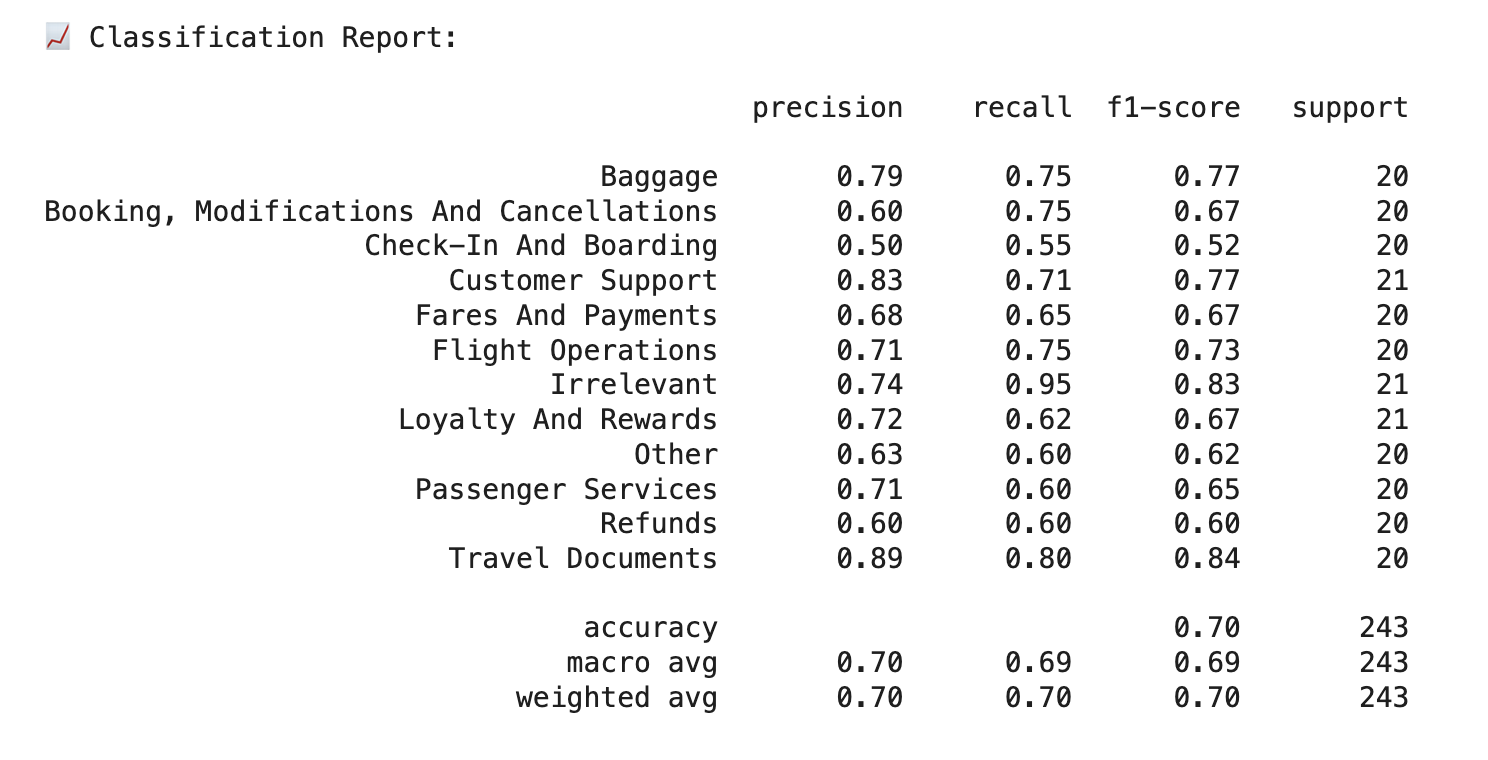

###**BERT WITH BERT EMBEDDINGS**

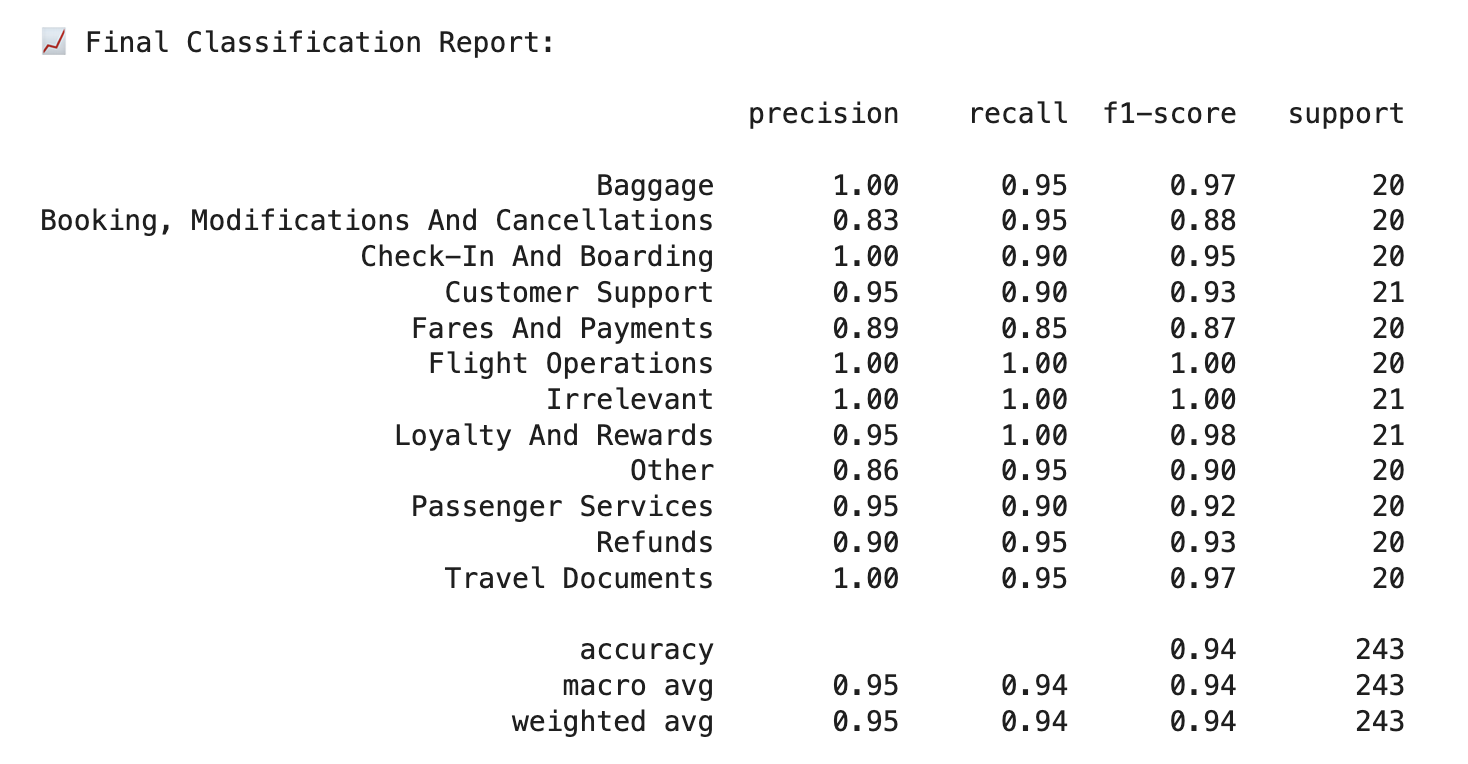

###**DISTILBERT WITH BERT EMBEDDINGS**

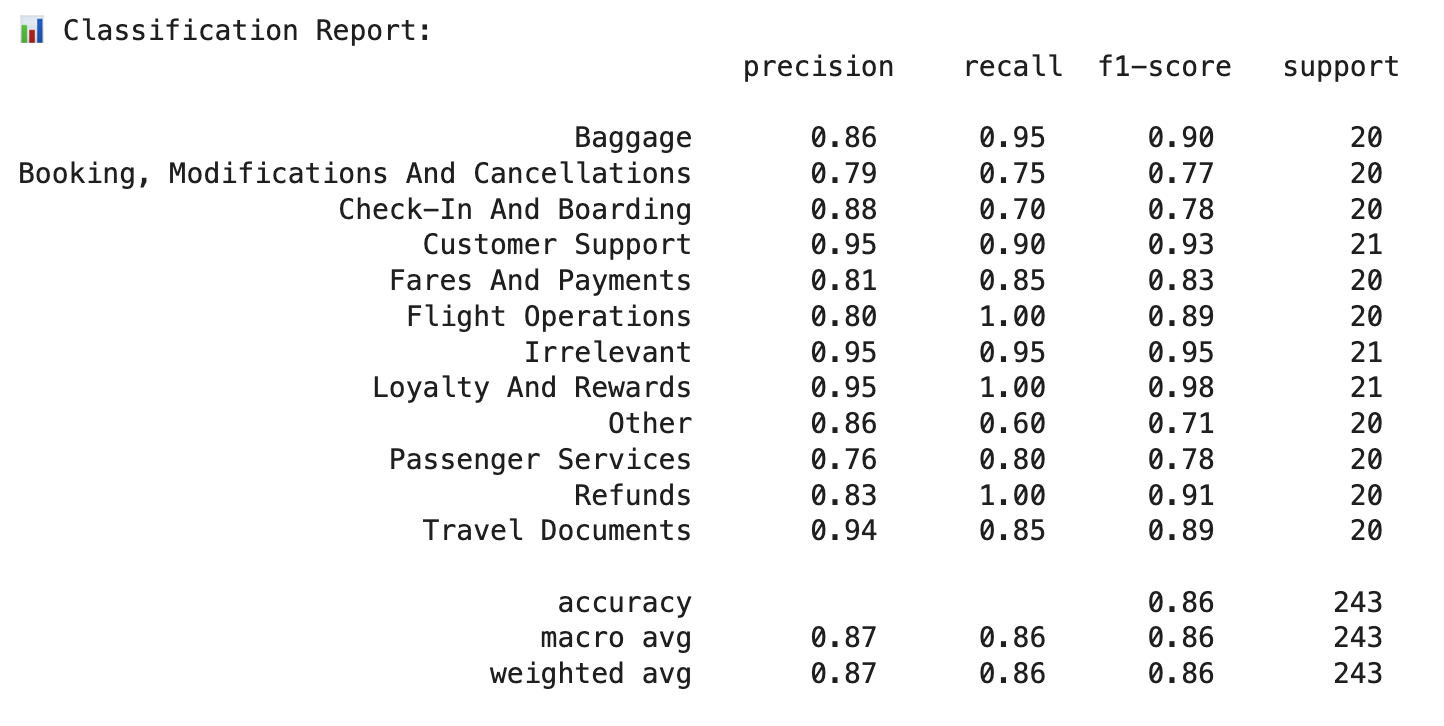